In [4]:
!pip install scikit-learn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 69.3 MB/s eta 0:00:00a 0:00:01


In [1]:
import pandas as pd
import numpy as np
import os 
import glob
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances
from sklearn import metrics
import pickle

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import BaseEstimator


import seaborn as sns

#a updated version of savvastj/nbashots used for kde shot plots had to update from 9 year old seaborn syntax
#import shot_printer as sp

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

#for shot ploting
#import importlib



# Import and Clean data
data fetched from NBA API using methods in get_data.ipynb

In [2]:
data_path = 'Data/'

In [107]:
#input dataframes

player_box_data= pd.read_csv(data_path + 'player_box_data_13_to_24.csv')
player_tracking_data= pd.read_csv(data_path + 'playertracking_data_13_to_24.csv')
player_shotchart_data = pd.read_csv(data_path + 'player_shotchart_data_13_to_24.csv')
player_advanced_box_data = pd.read_csv(data_path + 'player_advanced_box_data_13_to_24.csv')

team_game_adv_stats = pd.read_csv(data_path + 'team_advanced_stats_per_game_2013_to_2024.csv')
team_game_stats = pd.read_csv(data_path + 'nba_team_game_logs_2013_to_2024.csv')
player_game_stats = pd.read_csv(data_path + 'nba_player_game_logs_2013_to_2024.csv')

#have data not using
#player_play_by_play = pd.read_csv(data_path + 'player_play_by_play_data_23_to_24.csv')
player_play_type = pd.read_csv(data_path + 'player_play_type_data_13_to_24.csv')

In [109]:
#columns with no data for all players
player_box_data.dropna(inplace=True,axis =1 )

# Create key columns
player_advanced_box_data['combined_key'] = player_advanced_box_data['gameId'].astype(str) + '_' + player_advanced_box_data['personId'].astype(str)
player_tracking_data['combined_key'] = player_tracking_data['gameId'].astype(str) + '_' + player_tracking_data['personId'].astype(str)
player_box_data['combined_key'] = player_box_data['gameId'].astype(str) + '_' + player_box_data['personId'].astype(str)

#merge on key drop duplcated columns
#https://stackoverflow.com/questions/19125091/pandas-merge-how-to-avoid-duplicating-columns
big_box = player_advanced_box_data.merge(player_tracking_data, on='combined_key', how='outer', suffixes=('', '_y'))
big_box.drop(big_box.filter(regex='_y$').columns, axis=1, inplace=True)

big_box = big_box.merge(player_box_data, on='combined_key', how='outer', suffixes=('', '_y'))
big_box.drop(big_box.filter(regex='_y$').columns, axis=1, inplace=True)

big_box.drop(columns=['combined_key'],inplace=True)

#na values
    #position: non starters have no position data, Drop will make our own
    #comment: only rows with values are for did not play coaches dcision or Injury, and na
    #jerseyNum: not a single value, Drop no value
    #minutes: inverse of comment collumn, fill zeros

big_box = big_box.drop(columns=['jerseyNum','Unnamed: 0','GAME_ID'])
big_box.fillna({'minutes' : '00:00', 'position' : 'n','comment' : 'none'},inplace=True)

#dont know why 3 rows of nan
big_box.dropna(inplace=True,axis=0)

In [110]:

player_box_data['game_year'] = player_box_data['gameId'].astype(str).str[:3].astype(int)
unique_years = player_box_data['game_year'].unique()
unique_years

array([213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 222])

In [27]:
df_team_stats = team_game_stats.merge(team_game_adv_stats, on=['GAME_ID', 'TEAM_ID'], how='inner')
# W to 1 and L to 0
df_team_stats['WL'] = df_team_stats['WL'].apply(lambda x: 1 if x == 'W' else 0)

# removes "Rank" columns
df_team_stats = df_team_stats.drop(columns=[col for col in df_team_stats.columns if col.endswith('RANK')])

#rebounds
null_or_zero_oreb_pct = df_team_stats[(df_team_stats['OREB_PCT'].isnull()) | (df_team_stats['OREB_PCT'] == 0)]

#find rows with absolutely no reb data
no_rebounding_data = df_team_stats[
    (df_team_stats['OREB_PCT'].isnull() | (df_team_stats['OREB_PCT'] == 0)) &
    (df_team_stats['DREB_PCT'].isnull() | (df_team_stats['DREB_PCT'] == 0)) &
    (df_team_stats['REB_PCT'].isnull() | (df_team_stats['REB_PCT'] == 0))
]

#Home Away
df_team_stats['HOME_AWAY'] = df_team_stats['MATCHUP'].apply(lambda x: 1 if 'vs' in x else 0)

# Create opponent statistics using the GAME_ID
df_team_stats['OppOREB'] = df_team_stats.groupby('GAME_ID')['OREB'].shift(-1)
df_team_stats['OppDREB'] = df_team_stats.groupby('GAME_ID')['DREB'].shift(-1)
df_team_stats['OppREB'] = df_team_stats.groupby('GAME_ID')['REB'].shift(-1)

# Apply the same logic in reverse for the other team in the same game
df_team_stats['OppOREB'].fillna(df_team_stats.groupby('GAME_ID')['OREB'].shift(1), inplace=True)
df_team_stats['OppDREB'].fillna(df_team_stats.groupby('GAME_ID')['DREB'].shift(1), inplace=True)
df_team_stats['OppREB'].fillna(df_team_stats.groupby('GAME_ID')['REB'].shift(1), inplace=True)

# fill missing OREB_PCT, DREB_PCT, and REB_PCT values using the rebounding formulas
df_team_stats['OREB_PCT'] = np.where(df_team_stats['OREB_PCT'].isnull(),
                                      df_team_stats['OREB'] / (df_team_stats['OREB'] + df_team_stats['OppDREB']),
                                      df_team_stats['OREB_PCT'])

df_team_stats['DREB_PCT'] = np.where(df_team_stats['DREB_PCT'].isnull(),
                                      df_team_stats['DREB'] / (df_team_stats['DREB'] + df_team_stats['OppOREB']),
                                      df_team_stats['DREB_PCT'])

df_team_stats['REB_PCT'] = np.where(df_team_stats['REB_PCT'].isnull(),
                                     df_team_stats['REB'] / (df_team_stats['REB'] + df_team_stats['OppREB']),
                                     df_team_stats['REB_PCT'])

#dropping available flag, usage %, and newly-created opp reb. Team usage % for a game is going to be 100%, so it's not useful data
df_team_stats = df_team_stats.drop(columns=['USG_PCT', 'AVAILABLE_FLAG','OppOREB','OppDREB','OppREB'])

# sort
df_team_stats = df_team_stats.sort_values(by=['TEAM_ID', 'SEASON_YEAR', 'GAME_ID'])

# create cumulative wins and games played columns
df_team_stats['cumulative_wins'] = 0
df_team_stats['games_played'] = 0
df_team_stats['win_percentage'] = np.nan  # Initialize win_percentage as NaN for the first game of the season

# group by TEAM_ID and SEASON_YEAR, and calculate cumulative wins and games played
for team_id, team_data in df_team_stats.groupby(['TEAM_ID', 'SEASON_YEAR']):
    team_data = team_data.copy()
    team_data['cumulative_wins'] = team_data['WL'].cumsum().shift(1)  # Shift by 1 to exclude the current game
    team_data['games_played'] = np.arange(1, len(team_data) + 1)
    team_data.loc[team_data['games_played'] == 1, ['cumulative_wins', 'win_percentage']] = np.nan  # Set first game stats to NaN
    team_data['win_percentage'] = team_data['cumulative_wins'] / (team_data['games_played'] - 1)

    # assign the calculated values back to the main dataframe
    df_team_stats.loc[team_data.index, 'cumulative_wins'] = team_data['cumulative_wins']
    df_team_stats.loc[team_data.index, 'games_played'] = team_data['games_played']
    df_team_stats.loc[team_data.index, 'win_percentage'] = team_data['win_percentage']

# now, the first game of each season will have NaN for win_percentage and cumulative_wins
df_team_stats['games_played'] = df_team_stats['games_played'].replace(0, 1)  # ensure no division by zero
df_team_stats['win_percentage'] = df_team_stats['cumulative_wins'] / (df_team_stats['games_played'] - 1)


#grab numerics
df_team_numeric = df_team_stats.select_dtypes(include=['float64', 'int64'])

In [28]:
invalid_win_percentage = df_team_stats[df_team_stats['win_percentage'] > 1]
print(invalid_win_percentage[['cumulative_wins', 'games_played']])

Empty DataFrame
Columns: [cumulative_wins, games_played]
Index: []


# Clustering players
### First a couple of handy functions

In [45]:
## select our scaler and define 2 k means functions that return differnt values 
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)
scaler = RobustScaler()

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import BaseEstimator

def k_means(X,n_cluster,n_rand):
    best_silhoutte = -100
    best_labels = None

    for trial in range(n_rand):
        random_state = np.random.randint(1,1000)
        clusterer = KMeans(n_clusters=n_cluster, random_state=random_state, n_init=500, init='random')
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X,cluster_labels)

        if silhouette_avg > best_silhoutte:
            best_labels = cluster_labels
    return best_labels, clusterer


def k_means_lite(X,n_cluster,n_rand):
    best_labels = None
    best_silhoutte = -100
    
    for trial in range(n_rand):
        random_state = np.random.randint(1,1000)
        clusterer = KMeans(n_clusters=n_cluster, random_state=random_state, n_init=500, init='random')
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X,cluster_labels)

        if silhouette_avg > best_silhoutte:
            best_labels = cluster_labels
    return best_labels
    

In [113]:
#Transforms the large dataframes with per game player statistcs into 1 nice dataframe that can be used for clustering

######box score data: DF, the shot data: shot_df and the play type data play_type
def cluster4000(df,shot_df, play_type):
    #remove the fluf
    df.drop([ 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug','firstName','possessions', #'gameId',
                                'familyName', 'nameI'],axis=1,inplace =True)
    df.drop(df.filter(like='estimated').columns, axis=1,inplace = True)

    #get players
    player_set = set(df['personId'])

    #convert time to seconds
    #https://stackoverflow.com/questions/63663747/pandas-convert-time-into-seconds-for-all-values-in-column
    df['minutes']=df['minutes'].apply(lambda x: float(x.split(':')[0])*60+float(x.split(':')[1]))
    
    #get season averages
    df_player = df.groupby('personId').mean(numeric_only=True).reset_index()


    #add average play time and % starting 5
    df_time = df.groupby('personId').agg(
        avg_minutes=('minutes', 'mean'), 
        games_started=('position', lambda x: (x != 'n').sum()),).reset_index()
    df_time['avg_minutes'] = df_time['avg_minutes'] /60

    df_player = df_player.merge(df_time, on = 'personId')    
 
    ######adding player shot location data

    shot_chart_num = shot_df.drop([
        'GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_NAME',
        'PERIOD', 'ACTION_TYPE', 'SHOT_TYPE', 'MINUTES_REMAINING', 'EVENT_TYPE',
        'SECONDS_REMAINING', 'GAME_DATE', 'HTM', 'VTM', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE'
    ], axis=1)

    player_shot_summaries = pd.DataFrame()

    # calculate shooting stats for different zones
    for player_id, player_df in shot_chart_num.groupby('PLAYER_ID'):

        zone_summary = player_df.groupby(['SHOT_ZONE_BASIC']).agg(
            shot_attempts=('SHOT_ATTEMPTED_FLAG', 'sum'),  # Change from size to sum
            made_shots=('SHOT_MADE_FLAG', 'sum')
        ).reset_index()
        
        # Add player ID and clean up columns
        zone_summary['PLAYER_ID'] = player_id
        zone_summary['Location'] = zone_summary['SHOT_ZONE_BASIC']
        zone_summary = zone_summary.drop(['SHOT_ZONE_BASIC'], axis=1)

        total_attempts = zone_summary['shot_attempts'].sum()

        zone_summary['usage_percentage'] = (zone_summary['shot_attempts'] / total_attempts) * 100
        zone_summary['making_percentage'] = (zone_summary['made_shots'] / zone_summary['shot_attempts']) * 100
    
        
        # Pivot and flatten columns
        pivot_table = zone_summary.pivot_table(
            index='PLAYER_ID',
            columns='Location',
            values=['usage_percentage', 'making_percentage'],  # 
            aggfunc='sum'
        )
        pivot_table.columns = [f'{stat}_{location}'.replace(' ', '_') for stat, location in pivot_table.columns]
        pivot_table.reset_index(inplace=True)
        
        player_shot_summaries = pd.concat([player_shot_summaries, pivot_table], ignore_index=True)

    #print(len(player_shot_summaries))
    # Merge with the box23_24_player DataFrame
    df_player_shots = df_player.merge(player_shot_summaries, left_on='personId', right_on='PLAYER_ID', how='outer',suffixes=('', '_y'))

    # Fill NaN values with 0 for people with no shots or missing shot positions
    df_player_shots = df_player_shots.fillna(0)

    ######add play type data ##### Doesnt work 
    play_type = play_type.pivot_table(index= 'PLAYER_ID', columns= ['TYPE_GROUPING','PLAY_TYPE'], values='PERCENTILE').fillna(0)
    play_type.columns = ['{}_{}'.format(col[0], col[1]).replace(' ', '').strip('_') for col in play_type.columns.values]
    play_type = play_type.reset_index()

    df_player_shots['personId'] = df_player_shots['personId'].astype(int)
    play_type['PLAYER_ID'] = play_type['PLAYER_ID'].astype(int)
    
    
    df_player_shots = df_player_shots.merge(play_type, left_on='personId', right_on='PLAYER_ID')

    
    #data's ready drop the ID's and scale
    try:
        to_cluster = df_player_shots.drop(['PLAYER_ID'],axis = 1)
    except: 
        to_cluster = df_player_shots
    #scaled_box = RobustScaler().fit_transform(to_cluster)
    #scaled_df = pd.DataFrame(scaled_box, columns=to_cluster.columns)

    to_cluster.drop(['PLAYER_ID_y',"PLAYER_ID_x",'netRating','offensiveReboundPercentage','defensiveReboundPercentage','turnoverRatio','trueShootingPercentage','pace'],axis = 1, inplace=True) #'PLAYER_ID_y',"PLAYER_ID_x",


    
    return to_cluster#, play_type

## Getting to work 

Number of components to explain 90.0% of variance: 29


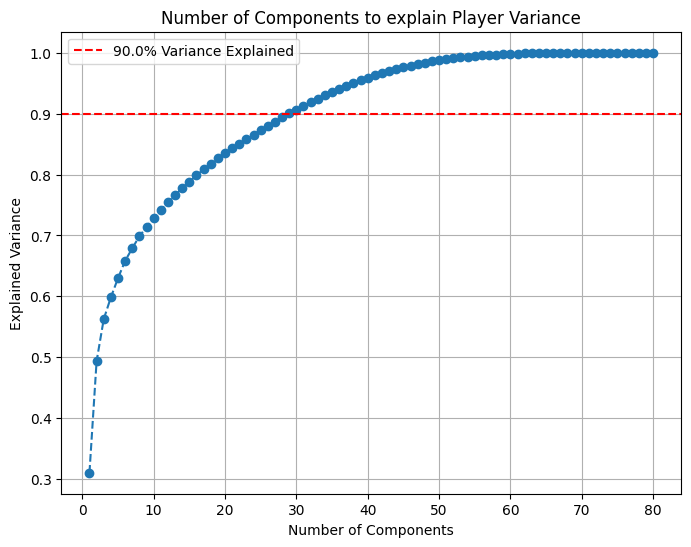

In [221]:
#Build the cluster model and PCA on the training data, leaving out test seasons 22-23 and 23-24
from sklearn.decomposition import PCA


n_cluster = 10 # circle back 

filtered_big_box = big_box[big_box['usagePercentage'] > 0.01]
filtered_big_box = filtered_big_box[filtered_big_box['gameId'] < 22200000 ] # dont train on data from test seasons 
filtered_big_box_persons = filtered_big_box['personId']

filtered_player_shotchart_data =  player_shotchart_data[player_shotchart_data['GAME_ID'] < 22200000]
filtered_player_shotchart_data = filtered_player_shotchart_data[filtered_player_shotchart_data['PLAYER_ID'].isin(filtered_big_box_persons)]

filtered_player_play_type =  player_play_type[player_play_type['SEASON_ID'] < 22022]
filtered_player_play_type = filtered_player_play_type[filtered_player_play_type['PLAYER_ID'].isin(filtered_big_box_persons)]

X= cluster4000(filtered_big_box,filtered_player_shotchart_data, filtered_player_play_type) # fit training players to cluster 
ids = X[['personId','gameId']]
X.drop(['personId','gameId','minutes','PIE','Defensive_PRBallHandler'],axis =1, inplace=True)
X = pd.DataFrame(X)
scaled_X = scaler.fit_transform(X)

scaled_X_df = pd.DataFrame(scaled_X, columns=X.columns)
labeled_X = pd.concat([ids.reset_index(drop=True), scaled_X_df], axis=1)

#pca test
pca = PCA()
pca.fit(scaled_X)
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
var_thresh = 0.90 
optimal_components = np.argmax(cumulative_explained_variance >= var_thresh) + 1
print(f"Number of components to explain {var_thresh*100}% of variance: {optimal_components}")

#PCA proper 
pca = PCA(n_components=optimal_components)
pca_X = pca.fit_transform(scaled_X)

big_cluster_labels, model = k_means(pca_X,n_cluster,10)

#X['personId'] = ids['personId']
#X['Cluster_Label'] = big_cluster_labels

labeled_X['clusters'] = big_cluster_labels

# PLOT PLOT PLOT
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title("Number of Components to explain Player Variance")
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.axhline(y=var_thresh, color='r', linestyle='--', label=f'{var_thresh*100}% Variance Explained')
plt.legend()
plt.savefig('charts/pca.png')
plt.show()


In [271]:
#with open('k_means_model.pkl', 'wb') as file: pickle.dump(model,file)

In [272]:
with open('k_means_model.pkl', 'rb') as file: model = pickle.load(file)

In [222]:
labeled_X

,personId,gameId,offensiveRating,defensiveRating,assistPercentage,assistToTurnover,assistRatio,reboundPercentage,effectiveFieldGoalPercentage,usagePercentage,pacePer40,speed,distance,reboundChancesOffensive,reboundChancesDefensive,reboundChancesTotal,touches,secondaryAssists,freeThrowAssists,passes,assists,contestedFieldGoalsMade,contestedFieldGoalsAttempted,contestedFieldGoalPercentage,uncontestedFieldGoalsMade,uncontestedFieldGoalsAttempted,uncontestedFieldGoalsPercentage,fieldGoalPercentage,defendedAtRimFieldGoalsMade,defendedAtRimFieldGoalsAttempted,defendedAtRimFieldGoalPercentage,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,avg_minutes,games_started,making_percentage_Above_the_Break_3,making_percentage_In_The_Paint_(Non-RA),making_percentage_Left_Corner_3,making_percentage_Mid-Range,making_percentage_Restricted_Area,making_percentage_Right_Corner_3,usage_percentage_Above_the_Break_3,usage_percentage_In_The_Paint_(Non-RA),usage_percentage_Left_Corner_3,usage_percentage_Mid-Range,usage_percentage_Restricted_Area,usage_percentage_Right_Corner_3,making_percentage_Backcourt,usage_percentage_Backcourt,Defensive_Handoff,Defensive_Isolation,Defensive_OffScreen,Defensive_PRRollMan,Defensive_Postup,Defensive_Spotup,Offensive_Cut,Offensive_Handoff,Offensive_Isolation,Offensive_Misc,Offensive_OffRebound,Offensive_OffScreen,Offensive_PRBallHandler,Offensive_PRRollMan,Offensive_Postup,Offensive_Spotup,Offensive_Transition,clusters
0,708,2.138892e+07,-0.342024,-1.371659,0.144850,-0.124650,0.630528,1.958209,-0.114536,-0.419269,-1.833762,-0.752340,-0.396919,-0.160555,1.351628,0.759908,0.340431,-0.455244,-0.428828,0.681572,-0.150656,-0.541567,-0.351213,-0.286620,-0.044597,-0.302664,1.448931,0.603606,0.286422,0.414363,0.510485,-0.308862,-0.361635,0.603438,-1.223228,-1.323879,-1.831471,-0.621827,-0.692762,-0.512380,0.023762,1.641784,1.193754,0.640643,0.243107,-0.245922,0.691827,-0.537287,0.346340,-0.195712,0.232887,-1.263761,0.398317,-1.749308,0.801680,-0.394035,-1.690568,-1.547438,0.159176,-1.159960,4.385178,-0.912895,-1.078090,-0.173939,-0.637521,-1.155455,1.748705,-1.346929,1.221253,0.357037,1.125161,-0.916531,-0.957890,-1.067057,-0.787762,-0.856556,1.441038,-1.025335,0.294698,1.203026,0.197587,-0.105887,8
1,951,2.130062e+07,0.914087,-0.541558,-0.116579,-0.087841,0.357742,-0.756488,0.891835,-0.542113,-2.399893,-0.117626,0.864690,-0.575065,-0.053220,-0.238054,-0.073727,0.032571,0.108099,-0.154910,0.099062,-0.490274,-0.432054,-0.290714,0.715338,0.627441,0.740294,0.113381,0.077195,-0.295065,2.112653,0.133943,0.164512,0.114373,1.177144,1.082365,1.213219,0.156943,-0.092579,0.936130,-0.813009,-0.134139,-0.379260,0.325790,-0.798662,0.081224,-0.337176,0.300006,1.251944,0.968452,-0.655027,0.389323,1.818619,0.405958,0.743784,0.049981,0.821148,0.483346,-1.035292,1.535781,0.133484,-0.910164,2.098191,3.572978,0.754316,1.325440,0.745283,-0.509193,1.444114,1.302456,-1.076010,-0.493459,-0.957890,-0.040947,1.475413,-1.171792,0.644013,1.122790,-0.843805,-0.739074,1.857218,1.383071,6
2,959,2.130059e+07,-0.603363,0.808380,3.684816,2.896265,3.536834,-1.128143,-0.395585,-0.181223,0.905355,1.291171,0.201022,-0.783354,-0.518827,-0.658668,1.147095,2.775860,0.978473,1.536077,2.653541,-0.545727,-0.275513,-1.125504,-0.147494,-0.030072,0.517861,-0.350365,-0.623572,-1.015353,1.068963,-0.396575,-0.169004,-0.352737,-0.424839,-0.442849,0.615562,0.184322,-0.084104,0.371511,-0.884086,-0.717968,-0.825521,-0.517082,-0.732243,1.520242,-0.983779,-0.306549,-1.466066,0.109383,-0.648197,0.356910,0.666443,-1.749308,0.077263,-1.527171,-1.690568,0.049253,0.510064,-1.190199,2.474860,-1.252894,-1.179134,-0.173939,-0.637521,-1.155455,-1.637845,-1.346929,-1.178522,-1.462708,2.171016,-1.334890,-0.772825,-1.067057,-1.396797,-1.171792,-0.933151,1.472

In [97]:
unique_values, counts = np.unique(big_cluster_labels, return_counts=True)

# Combine them into a structured array for better display
print(f"clusters: {n_cluster} players: {len(big_cluster_labels)}")
np.vstack((unique_values, counts)).T


clusters: 10 players: 1020


array([[  0, 149],
       [  1,  91],
       [  2,  45],
       [  3, 135],
       [  4, 112],
       [  5, 108],
       [  6,  44],
       [  7,  55],
       [  8, 140],
       [  9, 141]])

In [115]:
unique_values, counts = np.unique(big_cluster_labels, return_counts=True)

# Combine them into a structured array for better display
print(f"clusters: {n_cluster} players: {len(big_cluster_labels)}")
np.vstack((unique_values, counts)).T


clusters: 10 players: 1020


array([[  0, 152],
       [  1,  55],
       [  2,  88],
       [  3, 161],
       [  4, 123],
       [  5, 119],
       [  6,  98],
       [  7, 114],
       [  8,  60],
       [  9,  50]])

In [ ]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
full_silhouette = silhouette_score(X, kmeans.labels_)
feature_silhouette_scores = {}

for feature in X.columns:

    X_reduced = X.drop(columns=[feature])
    kmeans.fit(X_reduced)
    reduced_silhouette = silhouette_score(X_reduced, kmeans.labels_)
    feature_silhouette_scores[feature] = reduced_silhouette

sorted_features = sorted(feature_silhouette_scores.items(), key=lambda x: x[1], reverse=True)

print("Silhouette score for each feature (removed):", sorted_features)


213
214
215
216
217
218
219
220
221
223


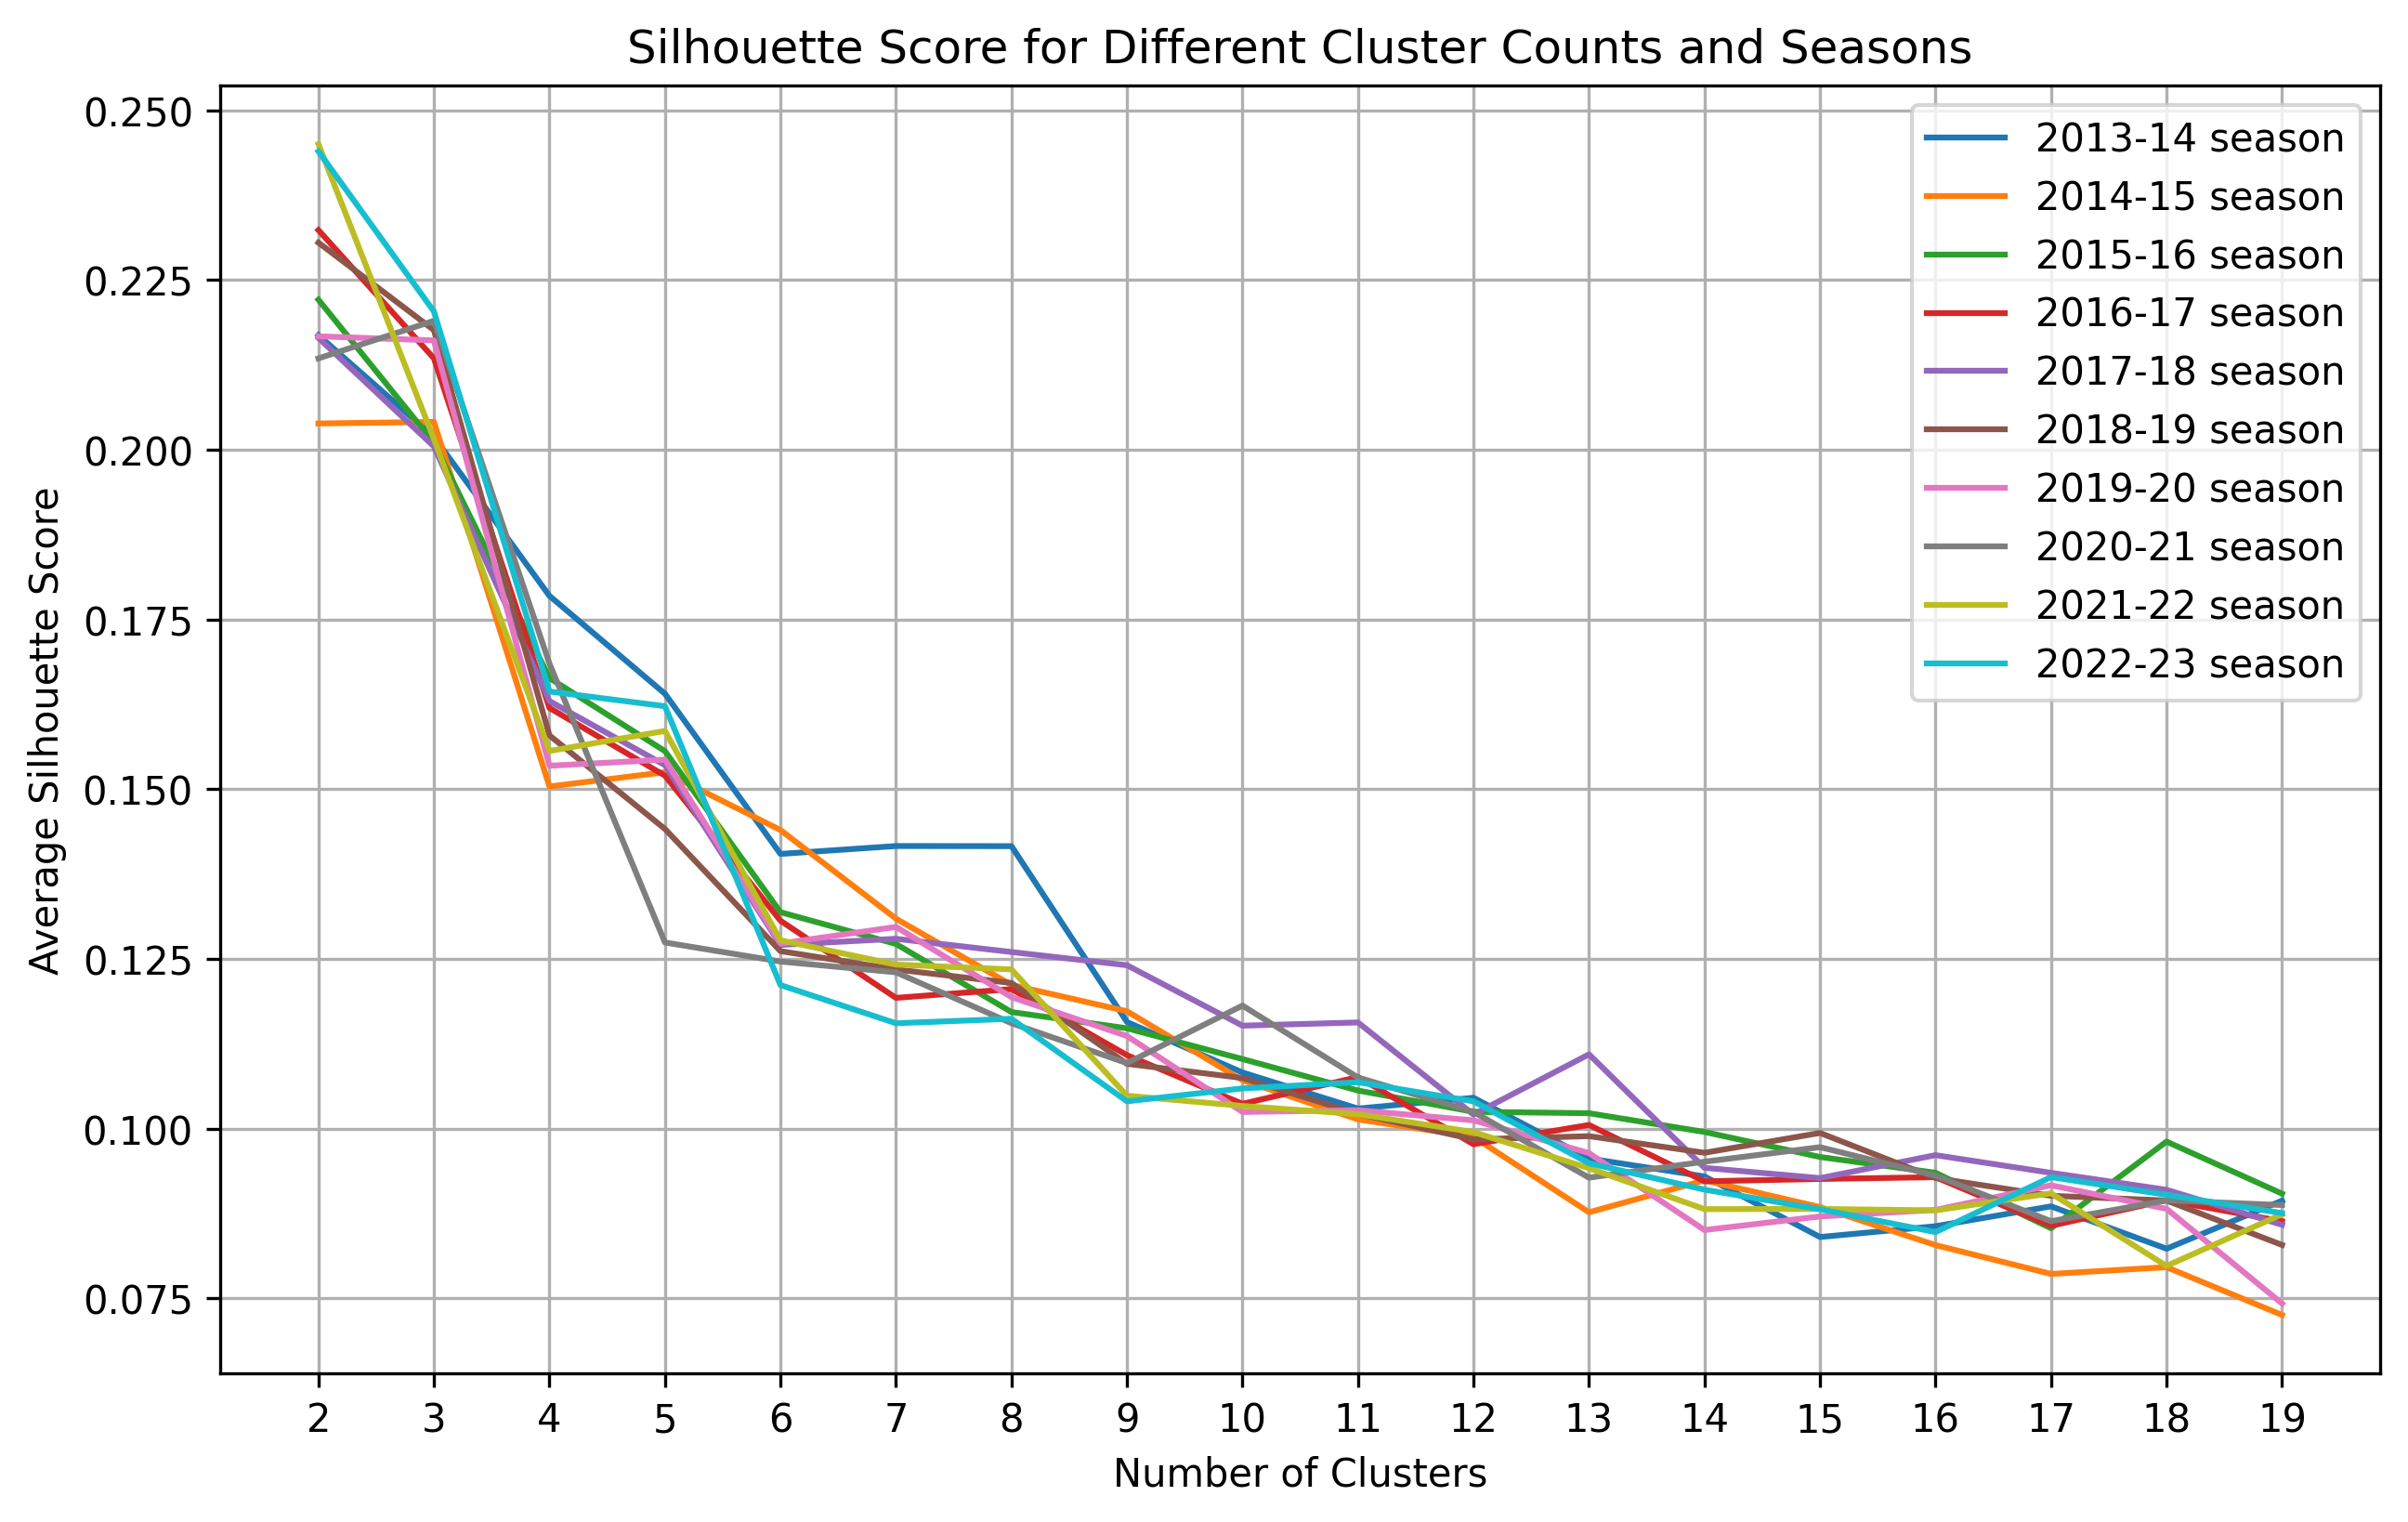

In [99]:
# Identify the correct number of clusters. 
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
season_prefixs = ['213','214','215','216','217','218','219','220','221','222','223'] #'222',
games = list(set(map(str, big_box['gameId'])))
season_game_dict = {}

test_range = range(2,20)

for s in season_prefixs:
    season_games = [game for game in games if game.startswith(s)]
    season_games = [float(g) for g in season_games]
    season_game_dict[s] = season_games
#iterate though season
season_cluster_dict = {}
#season_team_data_dict = {}
all_team_data = []

fig, ax = plt.subplots(figsize=(10, 6),dpi = 300)

custom_labels = [
    '2013-14 season', '2014-15 season', '2015-16 season', '2016-17 season',
    '2017-18 season', '2018-19 season', '2019-20 season', '2020-21 season',
    '2021-22 season', '2022-23 season', '2023-24 season'
]
custom_colors = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', '#ADD8E6'
]
# filter out unwanted players and remove 
filtered_big_box = big_box[big_box['usagePercentage'] > 0.05]
#filtered_big_box =# big_box.copy()#[big_box['gameId'] < 22200000 ] # dont train on data from test seasons 
filtered_big_box_persons = filtered_big_box['personId']

filtered_player_shotchart_data =  player_shotchart_data.copy()#[player_shotchart_data['GAME_ID'] < 22200000]
filtered_player_shotchart_data = filtered_player_shotchart_data[filtered_player_shotchart_data['PLAYER_ID'].isin(filtered_big_box_persons)]

filtered_player_play_type =  player_play_type.copy()    #[player_play_type['SEASON_ID'] < 22022]
filtered_player_play_type = filtered_player_play_type[filtered_player_play_type['PLAYER_ID'].isin(filtered_big_box_persons)]

for idx, s in enumerate(season_game_dict):
    games = season_game_dict[s]
    #get seasons data
    season_big_box = filtered_big_box[filtered_big_box['gameId'].isin(games)]
    season_team_game_stats = team_game_stats[team_game_stats['GAME_ID'].isin(games)]
    season_shot_chart = filtered_player_shotchart_data[filtered_player_shotchart_data['GAME_ID'].isin(games)]
    season_player_play_type = filtered_player_play_type[filtered_player_play_type['SEASON_ID'].astype(str).str[-2:] == str(s)[-2:]].copy()

    
    
    cluster_big_box = season_big_box.copy()
    X = cluster4000(cluster_big_box,season_shot_chart, season_player_play_type) # get player dataframes for clustering
    X.drop(['personId','gameId','minutes','PIE','Defensive_PRBallHandler'],axis =1, inplace=True)
    #scale
    scalled_X = scaler.fit_transform(X)
    pca_X = pca.transform(scalled_X)
    
    silhouette_list = []
    for n_clusters in test_range:
        labels = k_means_lite(pca_X,n_clusters,n_rand=1)

        silhouette_avg = silhouette_score(pca_X,labels)
        silhouette_list.append(silhouette_avg)
        sample_silhouette_values = silhouette_samples(pca_X,labels)
        calinski_harabasz = calinski_harabasz_score(pca_X, labels)
        if 1==2:     
            print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is :",
                round(silhouette_avg,5),
                "caliniski harabasz score",
                round(metrics.calinski_harabasz_score(pca_X, labels),2)
            )

    print(s)
    ax.plot(test_range,silhouette_list,label=custom_labels[idx], color=custom_colors[idx])
    
ax.set_title('Silhouette Score for Different Cluster Counts and Seasons')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Average Silhouette Score')
ax.legend(loc='best')
ax.grid(True)
ax.set_xticks(test_range)
plt.show() 

fig.savefig('charts/silhouette_score_seasons.png', bbox_inches='tight', dpi=300)

#### Produce clustering results

In [117]:
#X = pd.DataFrame(X)
# Create the Dataframe of all of the cluster data 
filtered_big_box#make a dictonary of games in each season
season_prefixs = ['213','214','215','216','217','218','219','220','221','222','223']#,'222'
games = list(set(map(str, big_box['gameId'])))
season_game_dict = {}
for s in season_prefixs:
    season_games = [game for game in games if game.startswith(s)]
    season_games = [float(g) for g in season_games]
    season_game_dict[s] = season_games
#iterate though season
season_cluster_dict = {}

all_clusters = [f'cluster_{i}' for i in range(n_cluster+1)]


# filter out unwanted players and remove 
filtered_big_box = big_box[big_box['usagePercentage'] > 0]

filtered_big_box_persons = filtered_big_box['personId']

filtered_player_shotchart_data =  player_shotchart_data.copy()
filtered_player_shotchart_data = filtered_player_shotchart_data[filtered_player_shotchart_data['PLAYER_ID'].isin(filtered_big_box_persons)]

filtered_player_play_type =  player_play_type.copy()   
filtered_player_play_type = filtered_player_play_type[filtered_player_play_type['PLAYER_ID'].isin(filtered_big_box_persons)]



#season_team_data_dict = {}
all_team_data = []
prev_season_data = None

for s in season_game_dict:
    games = season_game_dict[s]
    #get seasons data
    season_big_box = filtered_big_box[filtered_big_box['gameId'].isin(games)]
    season_team_game_stats = team_game_stats[team_game_stats['GAME_ID'].isin(games)]
    season_shot_chart = filtered_player_shotchart_data[filtered_player_shotchart_data['GAME_ID'].isin(games)]
    season_player_play_type = filtered_player_play_type[filtered_player_play_type['SEASON_ID'].astype(str).str[-2:] == str(s)[-2:]].copy()


    #get clustering labels from the last season and create for the current season
    if prev_season_data is None:
        # get cluster information 
        to_cluster = cluster4000(season_big_box.copy(),season_shot_chart.copy(),season_player_play_type.copy())
        to_cluster = to_cluster[to_cluster['gameId'] > 1].reset_index(drop = True)
        player_id = to_cluster['personId']
        X_update = to_cluster.drop(['personId','gameId'],axis=1)
        X_update = X_update[X.columns]
        
        X_update_scale = scaler.fit_transform(X_update)
        X_update_scale_df = pd.DataFrame(X_update_scale, columns=X_update.columns)
        X_update_pca = pca.transform(X_update_scale_df)
        
        labels = model.predict(X_update_pca)
        cluster_labels = pd.DataFrame(player_id)
        cluster_labels['cluster'] = labels

        prev_season_data = to_cluster
    else:
        curr_to_cluster =  cluster4000(season_big_box.copy(),season_shot_chart.copy(),season_player_play_type.copy())
        curr_to_cluster = curr_to_cluster[curr_to_cluster['gameId'] > 1].reset_index(drop = True)
        
        missing_players = curr_to_cluster['personId'][~curr_to_cluster['personId'].isin(prev_season_data['personId'])]
        player_id = prev_season_data['personId']
        X_update = prev_season_data.drop(['personId','gameId'],axis=1)
        X_update = X_update[X.columns]

        X_update_scale = scaler.fit_transform(X_update)
        X_update_scale_df = pd.DataFrame(X_update_scale, columns=X_update.columns)
        X_update_pca = pca.transform(X_update_scale_df)
        
        labels = model.predict(X_update_pca)
        cluster_labels = pd.DataFrame(player_id, columns = ['personId'])
        cluster_labels['cluster'] = labels
        
        missing_cluster_labels = pd.DataFrame(missing_players, columns = ['personId'])
        missing_cluster_labels['cluster'] = n_cluster # give rookies a uniqie id

        cluster_labels = pd.concat([cluster_labels, missing_cluster_labels], ignore_index=True)

        #get ready for next season
        prev_season_data = curr_to_cluster
    
        
    #team_data_dict = {}
    #work through each team
    for teamId in big_box['teamId'].unique():
        #get data for individual and team, sort team data chronological
        team_data = season_team_game_stats[season_team_game_stats['TEAM_ID'] == teamId]
        team_data.sort_values(by=['TEAM_ID', 'SEASON_YEAR', 'GAME_DATE'],inplace=True )
        team_data.reset_index(drop=True, inplace=True)
        player_data = season_big_box[season_big_box['teamId']==teamId]

        team_data['rolling_games'] = [
            team_data['GAME_ID'][max(0, i-5):i].tolist() for i in range(len(team_data))
        ]

        for cluster in all_clusters:
            if cluster not in team_data.columns:
                team_data[cluster] = 0
             
        for idx in team_data.index:
            prev_games = team_data['rolling_games'][idx]
            if not prev_games:  # Skip if the list is empty
                continue
            all_players_stats = []
            for game in prev_games:
                players = player_data[player_data['gameId']== game]
                players_shot_chart = season_shot_chart[season_shot_chart['GAME_ID'].isin(prev_games)]
                all_players_stats.append(players[['personId','usagePercentage']])
            if all_players_stats:
                window_players_stats = pd.concat(all_players_stats, ignore_index=True)
                try:
                    season_player_play_type = season_player_play_type.reset_index()
                except:
                    pass
                
                window_players_stats = window_players_stats.merge(cluster_labels[['personId','cluster']], on='personId')
                #window_players_stats = window_players_stats.iloc[:,:2]
                
                grouped_stats = window_players_stats.groupby('cluster', as_index=False)['usagePercentage'].sum()
                pivoted_stats = grouped_stats.reset_index().pivot_table(index=grouped_stats.index, columns='cluster', values='usagePercentage', aggfunc='sum')

                pivoted_stats.columns = [f'cluster_{col}' for col in pivoted_stats.columns]

                for cluster in all_clusters:
                    if cluster not in pivoted_stats.columns:
                        pivoted_stats[cluster] = 0
                #sort and sum 
                pivoted_stats = pivoted_stats[sorted(pivoted_stats.columns, key=lambda x: int(x.split('_')[1]))]
                summed_stats = pivoted_stats.sum().to_frame().T

                #account for variation in number of games in window
                summed_stats = summed_stats / len(pivoted_stats)
                #add to team_data
                team_data.loc[idx, summed_stats.columns] = summed_stats.iloc[0]
                
        all_team_data.append(team_data)
        #team_data_dict[teamId] = team_data


    #season_team_data_dict[s] = team_data_dict
final_team_data = pd.concat(all_team_data, ignore_index=True)

# Team Rolling Setup

In [118]:
def apply_rolling_average_within_season(df, columns_to_roll, window=5):
    df = df.sort_values(by=['TEAM_ID', 'SEASON_YEAR', 'GAME_DATE'])
    for col in columns_to_roll:
        df[col + '_rolling'] = df.groupby(['TEAM_ID', 'SEASON_YEAR'])[col].rolling(window=window, min_periods=1).apply(lambda x: x[:-1].mean() if len(x) > 1 else np.nan).reset_index(level=[0,1], drop=True)
    return df

columns_to_roll = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
                   'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING', 'OFF_RATING',
                   'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO',
                   'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'E_USG_PCT', 'E_PACE', 'PACE',
                   'PACE_PER40', 'POSS', 'PIE']

df_team_stats_rolling = apply_rolling_average_within_season(df_team_stats, columns_to_roll, window=5)

In [119]:
df_team_final = df_team_stats_rolling.dropna()
df_team_final_num = df_team_final.select_dtypes(include=['float64', 'int64'])

columns_to_keep = [
    'TEAM_ID', 'GAME_ID', 'WL', 'HOME_AWAY', 'FGM_rolling', 'FGA_rolling', 'FG_PCT_rolling',
    'FG3M_rolling', 'FG3A_rolling', 'FG3_PCT_rolling', 'FTM_rolling', 'FTA_rolling', 'FT_PCT_rolling',
    'OREB_rolling', 'DREB_rolling', 'REB_rolling', 'AST_rolling', 'TOV_rolling', 'STL_rolling', 'BLK_rolling',
    'BLKA_rolling', 'PF_rolling', 'PFD_rolling', 'PTS_rolling', 'PLUS_MINUS_rolling', 'E_OFF_RATING_rolling',
    'OFF_RATING_rolling', 'E_DEF_RATING_rolling', 'DEF_RATING_rolling', 'E_NET_RATING_rolling', 'NET_RATING_rolling',
    'AST_PCT_rolling', 'AST_TOV_rolling', 'AST_RATIO_rolling', 'E_TM_TOV_PCT_rolling', 'TM_TOV_PCT_rolling',
    'EFG_PCT_rolling', 'TS_PCT_rolling', 'E_USG_PCT_rolling', 'E_PACE_rolling', 'PACE_rolling', 'PACE_PER40_rolling',
    'POSS_rolling', 'PIE_rolling'
]

df_team_final_num = df_team_final_num[columns_to_keep]

In [120]:
valid_game_ids = []

for game_id in df_team_final['GAME_ID'].unique():
    game_rows = df_team_final[df_team_final['GAME_ID'] == game_id]
    if (game_rows['WL'] == 1).sum() == 1 and (game_rows['WL'] == 0).sum() == 1:
        valid_game_ids.append(game_id)

df_team_final = df_team_final[df_team_final['GAME_ID'].isin(valid_game_ids)]

# Merge

In [121]:

to_merge = ['TEAM_ID','GAME_ID'] + all_clusters
big_df = df_team_final.merge(final_team_data[to_merge], on=['TEAM_ID','GAME_ID'])
big_df.drop(big_df.filter(regex='_y$').columns, axis=1, inplace=True)
big_df

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE,MATCHUP,WL,MIN_x,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,Season,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_AWAY,cumulative_wins,games_played,win_percentage,FGM_rolling,FGA_rolling,FG_PCT_rolling,FG3M_rolling,FG3A_rolling,FG3_PCT_rolling,FTM_rolling,FTA_rolling,FT_PCT_rolling,OREB_rolling,DREB_rolling,REB_rolling,AST_rolling,TOV_rolling,STL_rolling,BLK_rolling,BLKA_rolling,PF_rolling,PFD_rolling,PTS_rolling,PLUS_MINUS_rolling,E_OFF_RATING_rolling,OFF_RATING_rolling,E_DEF_RATING_rolling,DEF_RATING_rolling,E_NET_RATING_rolling,NET_RATING_rolling,AST_PCT_rolling,AST_TOV_rolling,AST_RATIO_rolling,E_TM_TOV_PCT_rolling,TM_TOV_PCT_rolling,EFG_PCT_rolling,TS_PCT_rolling,E_USG_PCT_rolling,E_PACE_rolling,PACE_rolling,PACE_PER40_rolling,POSS_rolling,PIE_rolling,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10
0,2013-14,1610612737,ATL,Atlanta Hawks,21300023,2013-11-01T00:00:00,ATL vs. TOR,1,48.0,36,77,0.468,10,23,0.435,20,31,0.645,7,30,37,24,13.0,7,3,6,12,25,102,7.0,2013-14,Atlanta,105.5,107.4,98.8,100.0,6.8,7.4,0.667,1.85,18.8,0.234000,0.720,0.485000,13.452,13.7,0.532,0.563,0.201,96.40,95.0,79.17,95,0.587,1,0.0,2,0.000000,37.000000,76.00,0.487000,8.00,24.00,0.333000,27.000000,35.000000,0.771000,5.000000,28.000000,33.000000,27.000000,17.000000,16.000000,5.000000,2.00,20.00,22.000000,109.000000,-9.000000,105.400000,104.800000,117.300000,114.600000,-11.900000,-9.800000,0.730000,1.590000,19.900000,16.441000,16.300,0.539000,0.596000,0.201000,101.980000,103.500000,86.250000,104.000000,0.46700,0.033625,0.054875,0.020875,0.029750,0.012500,0.020875,0.035250,0.000000,0.036625,0.0,0.000000
1,2013-14,1610612737,ATL,Atlanta Hawks,21300046,2013-11-03T00:00:00,ATL @ LAL,0,48.0,40,90,0.444,9,22,0.409,14,26,0.538,10,42,52,26,13.0,9,3,7,22,24,103,-2.0,2013-14,Atlanta,98.6,97.2,98.5,100.0,0.1,-2.8,0.650,2.00,18.5,0.175439,0.830,0.495238,12.447,12.3,0.494,0.508,0.197,105.50,105.5,87.92,106,0.476,0,1.0,3,0.500000,36.500000,76.50,0.477500,9.00,23.50,0.384000,23.500000,33.000000,0.708000,6.000000,29.000000,35.000000,25.500000,15.000000,11.500000,4.000000,4.00,16.00,23.500000,105.500000,-1.000000,105.450000,106.100000,108.050000,107.300000,-2.550000,-1.200000,0.698500,1.720000,19.350000,14.946500,15.000,0.535500,0.579500,0.201000,99.190000,99.250000,82.710000,99.500000,0.52700,0.072875,0.117625,0.035625,0.076500,0.012500,0.045125,0.051750,0.000000,0.065125,0.0,0.000000
2,2013-14,1610612737,ATL,Atlanta Hawks,21300059,2013-11-05T00:00:00,ATL @ SAC,1,48.0,39,81,0.481,8,22,0.364,19,26,0.731,9,27,36,26,14.0,11,7,4,15,26,105,5.0,2013-14,Atlanta,107.8,109.4,102.8,103.1,4.9,6.3,0.667,1.86,19.6,0.239000,0.717,0.478000,14.368,14.6,0.531,0.568,0.201,97.34,96.5,80.42,96,0.559,0,1.0,4,0.333333,37.666667,81.00,0.466333,9.00,23.00,0.392333,20.333333,30.666667,0.651333,7.333333,33.333333,40.666667,25.666667,14.333333,10.666667,3.666667,5.00,18.00,23.666667,104.666667,-1.333333,103.166667,103.133333,104.866667,104.866667,-1.666667,-1.733333,0.682333,1.813333,19.066667,14.113333,14.100,0.521667,0.555667,0.199667,101.293333,101.333333,84.446667,101.666667,0.51000,0.104750,0.169750,0.049500,0.129250,0.012500,0.096000,0.066875,0.000000,0.096375,0.0,0.000000
3,2013-14,1610612737,ATL,Atlanta Hawks,21300071,2013-11-07T00:00:00,ATL @ DEN,0,48.0,43,94,0.457,8,26,0.308,13,19,0.684,13,33,46,31,11.0,11,9,8,23,18,107,-2.0,2013-14,Atlanta,106.6,109.2,109.6,112.4,-3.0,-3.2,0.721,2.82,21.5,0.321000,0.745,0.520000,10.961,11.2,0.500,0.523,0.198,99.92,97.5,81.25,98,0.502,0,2.0,5,0.500000,38.000000,81.00,0.470000,8.75,22.75,0.385250,20.000000,29.500000,0.671250,7.750000,31.750000,39.500000,25.750000,14.250000,10.750000,4.500000,4.

In [207]:
big_df.to_csv('Data/2013-24_model_input_cluster_update_v5.csv',index=False)

In [278]:
len(big_df)

25980

In [68]:
big_df[big_df['GAME_ID'].astype(str).str.endswith('0015')]

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE,MATCHUP,WL,MIN_x,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,Season,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_AWAY,cumulative_wins,games_played,win_percentage,FGM_rolling,FGA_rolling,FG_PCT_rolling,FG3M_rolling,FG3A_rolling,FG3_PCT_rolling,FTM_rolling,FTA_rolling,FT_PCT_rolling,OREB_rolling,DREB_rolling,REB_rolling,AST_rolling,TOV_rolling,STL_rolling,BLK_rolling,BLKA_rolling,PF_rolling,PFD_rolling,PTS_rolling,PLUS_MINUS_rolling,E_OFF_RATING_rolling,OFF_RATING_rolling,E_DEF_RATING_rolling,DEF_RATING_rolling,E_NET_RATING_rolling,NET_RATING_rolling,AST_PCT_rolling,AST_TOV_rolling,AST_RATIO_rolling,E_TM_TOV_PCT_rolling,TM_TOV_PCT_rolling,EFG_PCT_rolling,TS_PCT_rolling,E_USG_PCT_rolling,E_PACE_rolling,PACE_rolling,PACE_PER40_rolling,POSS_rolling,PIE_rolling,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9


# EDA

In [127]:
big_df

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE,MATCHUP,WL,MIN_x,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,Season,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_AWAY,cumulative_wins,games_played,win_percentage,FGM_rolling,FGA_rolling,FG_PCT_rolling,FG3M_rolling,FG3A_rolling,FG3_PCT_rolling,FTM_rolling,FTA_rolling,FT_PCT_rolling,OREB_rolling,DREB_rolling,REB_rolling,AST_rolling,TOV_rolling,STL_rolling,BLK_rolling,BLKA_rolling,PF_rolling,PFD_rolling,PTS_rolling,PLUS_MINUS_rolling,E_OFF_RATING_rolling,OFF_RATING_rolling,E_DEF_RATING_rolling,DEF_RATING_rolling,E_NET_RATING_rolling,NET_RATING_rolling,AST_PCT_rolling,AST_TOV_rolling,AST_RATIO_rolling,E_TM_TOV_PCT_rolling,TM_TOV_PCT_rolling,EFG_PCT_rolling,TS_PCT_rolling,E_USG_PCT_rolling,E_PACE_rolling,PACE_rolling,PACE_PER40_rolling,POSS_rolling,PIE_rolling,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10
0,2013-14,1610612737,ATL,Atlanta Hawks,21300023,2013-11-01T00:00:00,ATL vs. TOR,1,48.0,36,77,0.468,10,23,0.435,20,31,0.645,7,30,37,24,13.0,7,3,6,12,25,102,7.0,2013-14,Atlanta,105.5,107.4,98.8,100.0,6.8,7.4,0.667,1.85,18.8,0.234000,0.720,0.485000,13.452,13.7,0.532,0.563,0.201,96.40,95.0,79.17,95,0.587,1,0.0,2,0.000000,37.000000,76.00,0.487000,8.00,24.00,0.333000,27.000000,35.000000,0.771000,5.000000,28.000000,33.000000,27.000000,17.000000,16.000000,5.000000,2.00,20.00,22.000000,109.000000,-9.000000,105.400000,104.800000,117.300000,114.600000,-11.900000,-9.800000,0.730000,1.590000,19.900000,16.441000,16.300,0.539000,0.596000,0.201000,101.980000,103.500000,86.250000,104.000000,0.46700,0.033625,0.054875,0.020875,0.029750,0.012500,0.020875,0.035250,0.000000,0.036625,0.0,0.000000
1,2013-14,1610612737,ATL,Atlanta Hawks,21300046,2013-11-03T00:00:00,ATL @ LAL,0,48.0,40,90,0.444,9,22,0.409,14,26,0.538,10,42,52,26,13.0,9,3,7,22,24,103,-2.0,2013-14,Atlanta,98.6,97.2,98.5,100.0,0.1,-2.8,0.650,2.00,18.5,0.175439,0.830,0.495238,12.447,12.3,0.494,0.508,0.197,105.50,105.5,87.92,106,0.476,0,1.0,3,0.500000,36.500000,76.50,0.477500,9.00,23.50,0.384000,23.500000,33.000000,0.708000,6.000000,29.000000,35.000000,25.500000,15.000000,11.500000,4.000000,4.00,16.00,23.500000,105.500000,-1.000000,105.450000,106.100000,108.050000,107.300000,-2.550000,-1.200000,0.698500,1.720000,19.350000,14.946500,15.000,0.535500,0.579500,0.201000,99.190000,99.250000,82.710000,99.500000,0.52700,0.072875,0.117625,0.035625,0.076500,0.012500,0.045125,0.051750,0.000000,0.065125,0.0,0.000000
2,2013-14,1610612737,ATL,Atlanta Hawks,21300059,2013-11-05T00:00:00,ATL @ SAC,1,48.0,39,81,0.481,8,22,0.364,19,26,0.731,9,27,36,26,14.0,11,7,4,15,26,105,5.0,2013-14,Atlanta,107.8,109.4,102.8,103.1,4.9,6.3,0.667,1.86,19.6,0.239000,0.717,0.478000,14.368,14.6,0.531,0.568,0.201,97.34,96.5,80.42,96,0.559,0,1.0,4,0.333333,37.666667,81.00,0.466333,9.00,23.00,0.392333,20.333333,30.666667,0.651333,7.333333,33.333333,40.666667,25.666667,14.333333,10.666667,3.666667,5.00,18.00,23.666667,104.666667,-1.333333,103.166667,103.133333,104.866667,104.866667,-1.666667,-1.733333,0.682333,1.813333,19.066667,14.113333,14.100,0.521667,0.555667,0.199667,101.293333,101.333333,84.446667,101.666667,0.51000,0.104750,0.169750,0.049500,0.129250,0.012500,0.096000,0.066875,0.000000,0.096375,0.0,0.000000
3,2013-14,1610612737,ATL,Atlanta Hawks,21300071,2013-11-07T00:00:00,ATL @ DEN,0,48.0,43,94,0.457,8,26,0.308,13,19,0.684,13,33,46,31,11.0,11,9,8,23,18,107,-2.0,2013-14,Atlanta,106.6,109.2,109.6,112.4,-3.0,-3.2,0.721,2.82,21.5,0.321000,0.745,0.520000,10.961,11.2,0.500,0.523,0.198,99.92,97.5,81.25,98,0.502,0,2.0,5,0.500000,38.000000,81.00,0.470000,8.75,22.75,0.385250,20.000000,29.500000,0.671250,7.750000,31.750000,39.500000,25.750000,14.250000,10.750000,4.500000,4.

In [77]:
big_cluster_labels
unique_values, counts = np.unique(big_cluster_labels, return_counts=True)

# Combine them into a structured array for better display
np.vstack((unique_values, counts)).T


array([[  0, 258],
       [  1,   1],
       [  2,   1],
       [  3, 104],
       [  4, 522],
       [  5,  71],
       [  6, 181],
       [  7, 119],
       [  8,   1],
       [  9,  24]])

In [69]:
big_df_scaled

,PLUS_MINUS_rolling,NET_RATING_rolling,PIE_rolling,cluster_10,win_percentage,OFF_RATING_rolling,TS_PCT_rolling,EFG_PCT_rolling,PTS_rolling,HOME_AWAY,DEF_RATING_rolling,WL
0,-1.078827,-1.167722,-0.637309,-0.935661,-2.767437,-0.623066,0.960027,0.390318,0.108243,1.0,0.747659,1
1,-0.121503,-0.144603,0.518305,-0.935661,-0.006538,-0.443802,0.525397,0.304081,-0.285031,-1.0,-0.282697,0
2,-0.161392,-0.208053,0.190881,-0.935661,-0.926838,-0.852891,-0.102402,-0.036762,-0.378668,-1.0,-0.626150,1
3,0.028079,0.030874,0.426819,-0.935661,-0.006538,-0.636856,-0.021183,0.020730,-0.369305,-1.0,-0.688489,0
4,0.237493,0.227170,0.595346,-0.935661,-0.558718,-0.485171,-0.501910,-0.219503,-0.425487,1.0,-0.766118,1
...,...,...,...,...,...,...,...,...,...,...,...,...
25975,-0.600165,-0.688879,-0.088393,4.291260,-1.442205,0.638675,1.223440,1.252691,-0.004121,1.0,1.474555,0
25976,-0.330918,-0.394435,0.325703,4.050231,-1.459643,0.504227,1.394658,1.338928,-0.004121,1.0,0.987605,0
25977,-0.689914,-0.715646,0.070505,4.456573,-1.476627,0.242226,1.302463,1.166454,-0.004121,-1.0,1.096992,1
25978,-0.570249,-0.590731,-0.136543,4.171377,-1.422384,1.166124,2.342942,2.108904,0.810519,-1.0,1.894460,0


In [77]:
team_stats_wl['OFF_RATING_rolling'] = team_stats_wl['OFF_RATING_rolling']/100
team_stats_wl['PTS_rolling'] = team_stats_wl['PTS_rolling']/100
team_stats_wl['DEF_RATING_rolling'] = team_stats_wl['DEF_RATING_rolling']/100

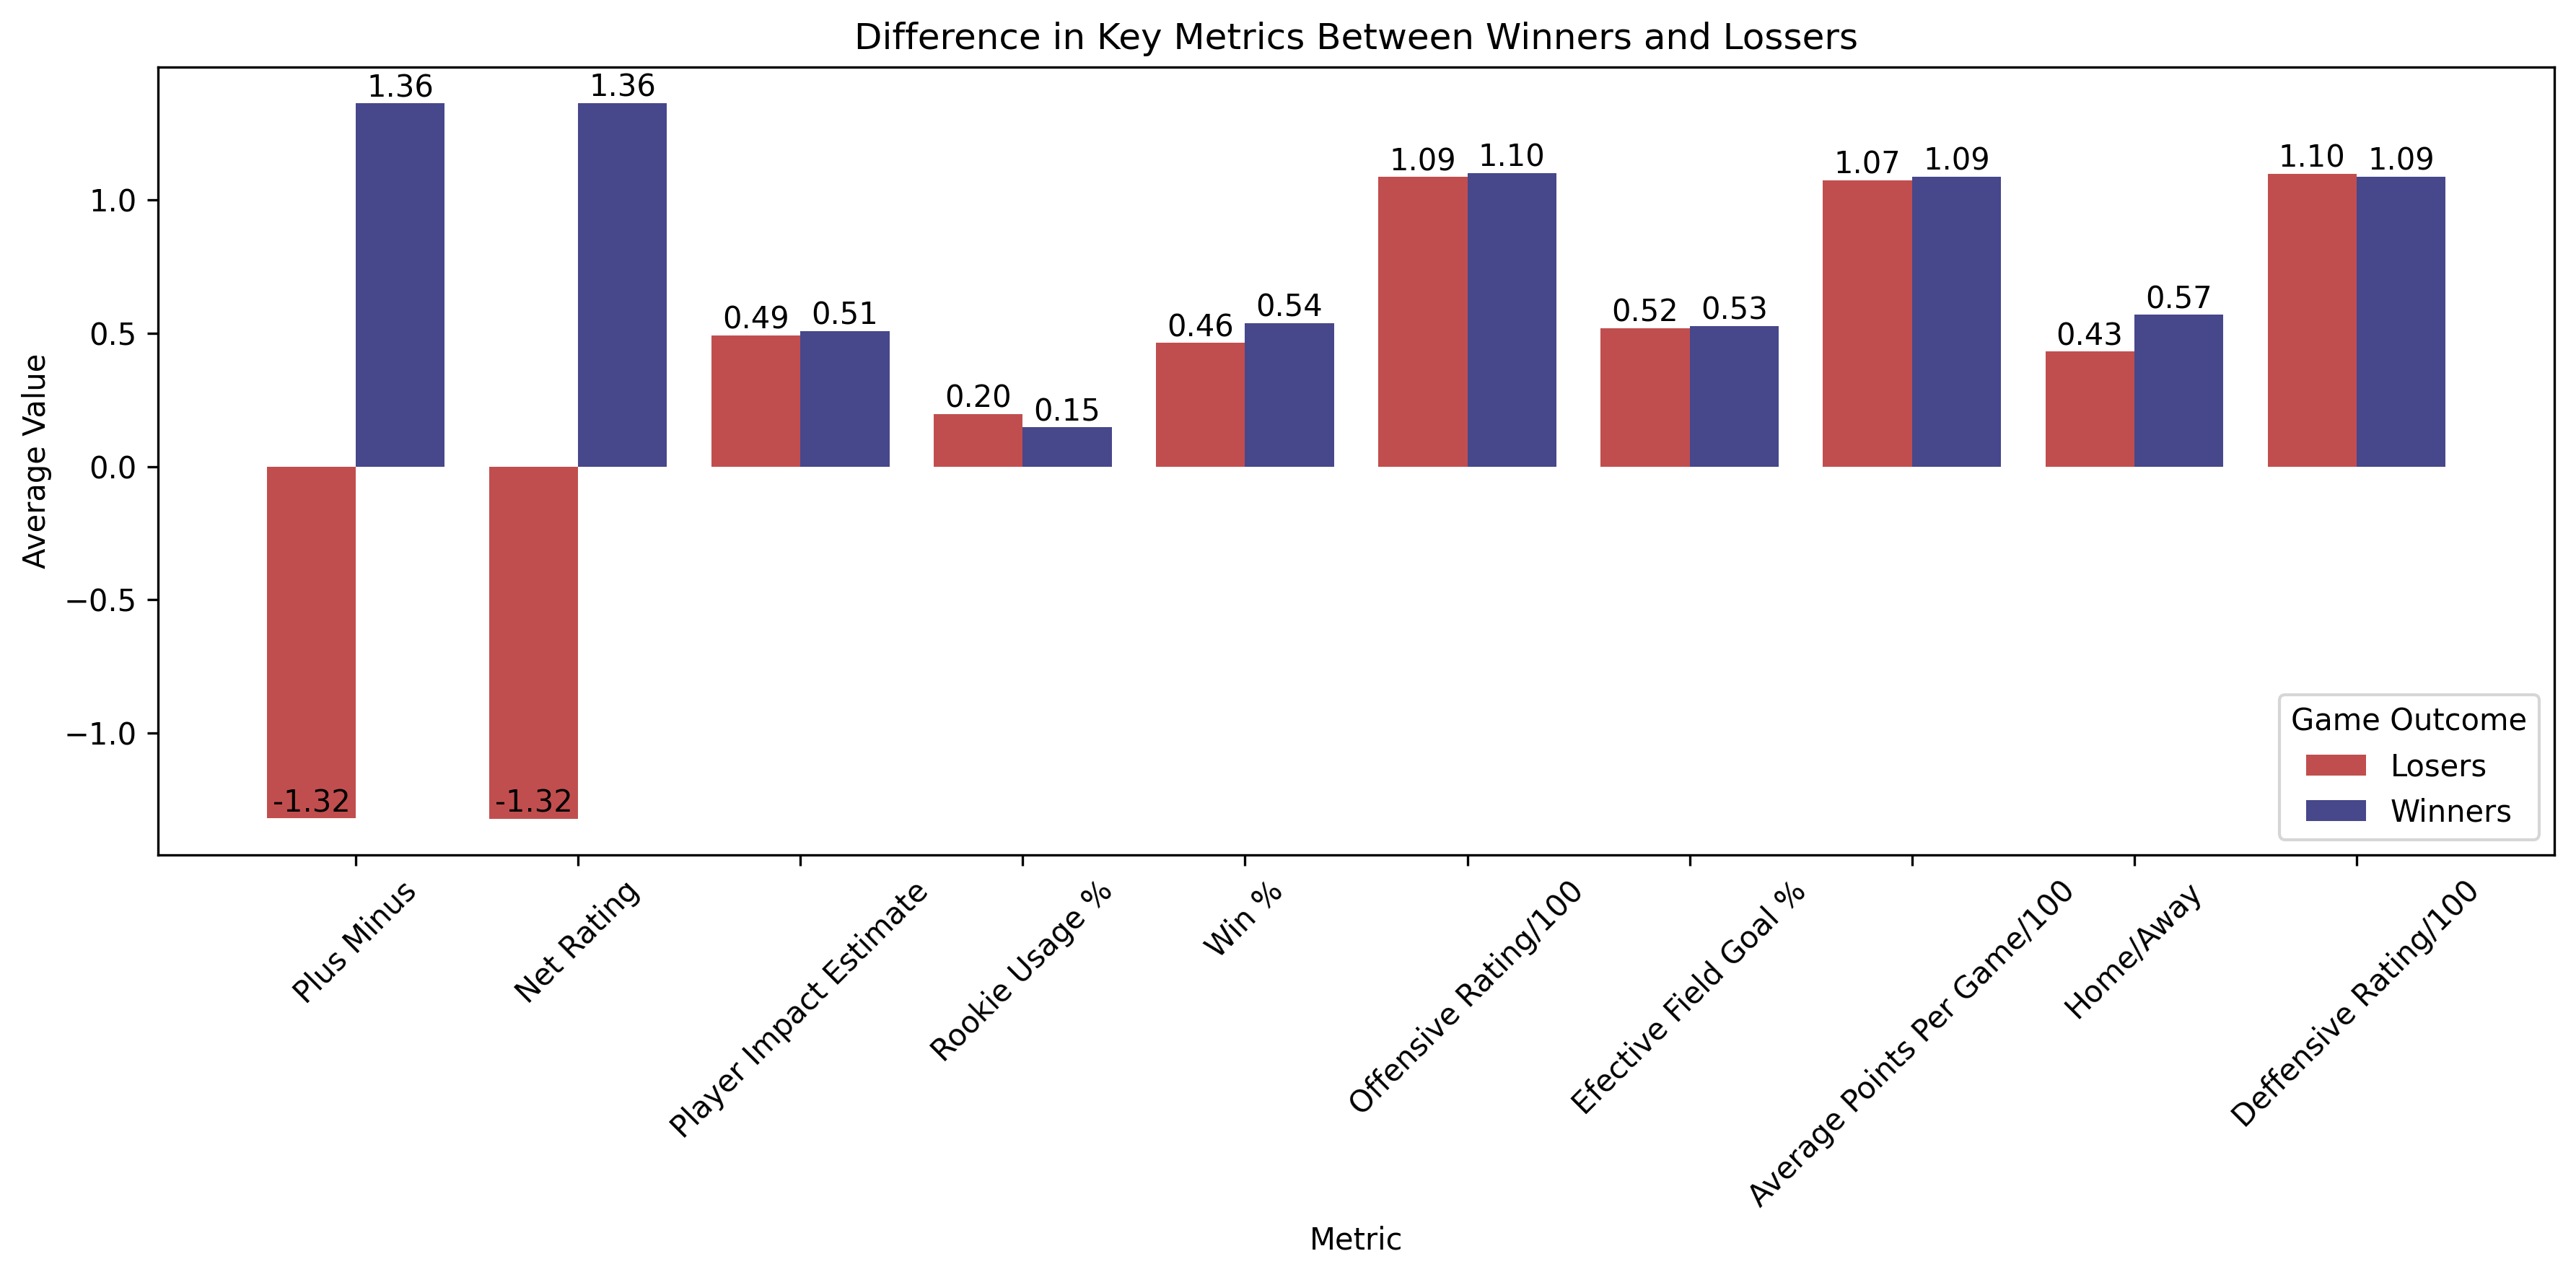

In [124]:
team_stats_wl = big_df.groupby('WL').agg({
    'PLUS_MINUS_rolling': 'mean',
    'NET_RATING_rolling': 'mean',
    'PIE_rolling': 'mean',
    'cluster_10': 'mean',
    'win_percentage': 'mean',
    'OFF_RATING_rolling': 'mean',
    'EFG_PCT_rolling': 'mean',
    'PTS_rolling': 'mean',
    'HOME_AWAY': 'mean',
    'DEF_RATING_rolling': 'mean',

}).reset_index()

team_stats_wl = team_stats_wl.iloc[:, 1:]

#make plot readable
team_stats_wl['OFF_RATING_rolling'] = team_stats_wl['OFF_RATING_rolling']/100
team_stats_wl['PTS_rolling'] = team_stats_wl['PTS_rolling']/100
team_stats_wl['DEF_RATING_rolling'] = team_stats_wl['DEF_RATING_rolling']/100

x_labels = [
    'Plus Minus', 'Net Rating', 'Player Impact Estimate', 'Rookie Usage %', 'Win %', 
    'Offensive Rating/100', 'Efective Field Goal %', 'Average Points Per Game/100', 'Home/Away', 'Deffensive Rating/100'
]

plt.figure(figsize=(12, 6), dpi = 300)
bar_width = 0.4  

indices = np.arange(10)

loser_bars =plt.bar(indices - bar_width / 2, team_stats_wl.loc[0, :], width=bar_width, 
        color='firebrick', alpha=0.8, label='Losers')

winner_bars = plt.bar(indices + bar_width / 2, team_stats_wl.loc[1, :], width=bar_width, 
        color='midnightblue', alpha=0.8, label='Winners')

for bar in loser_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)


for bar in winner_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)



plt.title('Difference in Key Metrics Between Winners and Lossers')
plt.xlabel('Metric')
plt.ylabel('Average Value')
plt.xticks(indices, x_labels, rotation=45)
plt.legend(title='Game Outcome')
plt.tight_layout()
plt.savefig('charts/metric_winner_loser.png')
plt.show()

<Figure size 3600x1800 with 0 Axes>

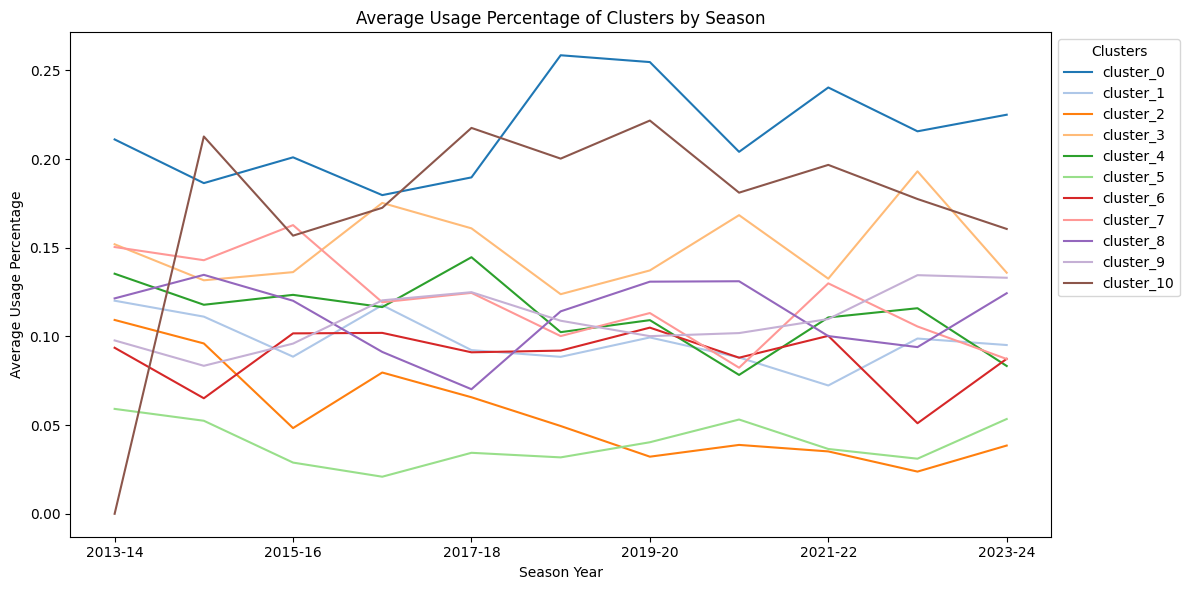

In [125]:
cluster_means = big_df.groupby('SEASON_YEAR').agg({
    'cluster_0': 'mean',
    'cluster_1': 'mean',
    'cluster_2': 'mean',
    'cluster_3': 'mean',
    'cluster_4': 'mean',
    'cluster_5': 'mean',
    'cluster_6': 'mean',
    'cluster_7': 'mean',
    'cluster_8': 'mean',
    'cluster_9': 'mean',
    'cluster_10': 'mean',


}).reset_index()

cluster_means.set_index('SEASON_YEAR', inplace=True)


plt.figure(figsize=(12, 6), dpi = 300)
cluster_means.plot(kind='line', figsize=(12, 6), color = plt.cm.tab20.colors)
plt.title('Average Usage Percentage of Clusters by Season')
plt.xlabel('Season Year')
plt.ylabel('Average Usage Percentage')
#plt.xticks(rotation=45)
plt.legend(title='Clusters', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('charts/usage_season.png')
plt.show()

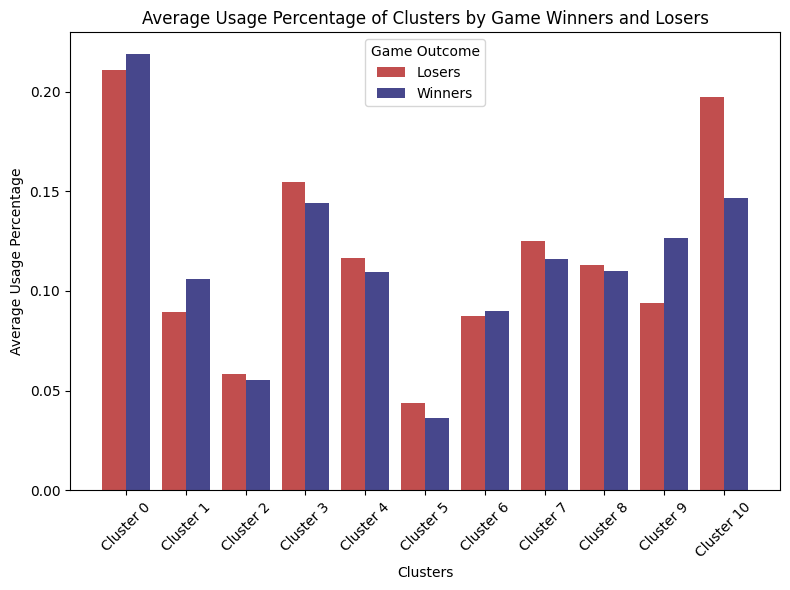

In [183]:
cluster_means = big_df.groupby('WL').agg({
    'cluster_0': 'mean',
    'cluster_1': 'mean',
    'cluster_2': 'mean',
    'cluster_3': 'mean',
    'cluster_4': 'mean',
    'cluster_5': 'mean',
    'cluster_6': 'mean',
    'cluster_7': 'mean',
    'cluster_8': 'mean',
    'cluster_9': 'mean',
    'cluster_10': 'mean'
}).reset_index()

cluster_means.set_index('WL', inplace=True)

plt.figure(figsize=(8, 6))

num_clusters = len(cluster_means.columns)
bar_width = 0.4  

indices = np.arange(num_clusters)

plt.bar(indices - bar_width / 2, cluster_means.loc[0, :], width=bar_width, 
        color='firebrick', alpha=0.8, label='Losers')

plt.bar(indices + bar_width / 2, cluster_means.loc[1, :], width=bar_width, 
        color='midnightblue', alpha=0.8, label='Winners')

plt.title('Average Usage Percentage of Clusters by Game Winners and Losers')
plt.xlabel('Clusters')
plt.ylabel('Average Usage Percentage')
plt.xticks(indices, [f'Cluster {i}' for i in range(num_clusters)], rotation=45)
plt.legend(title='Game Outcome')
plt.tight_layout()
plt.savefig('charts/cluster_winner_loser.png')
plt.show()

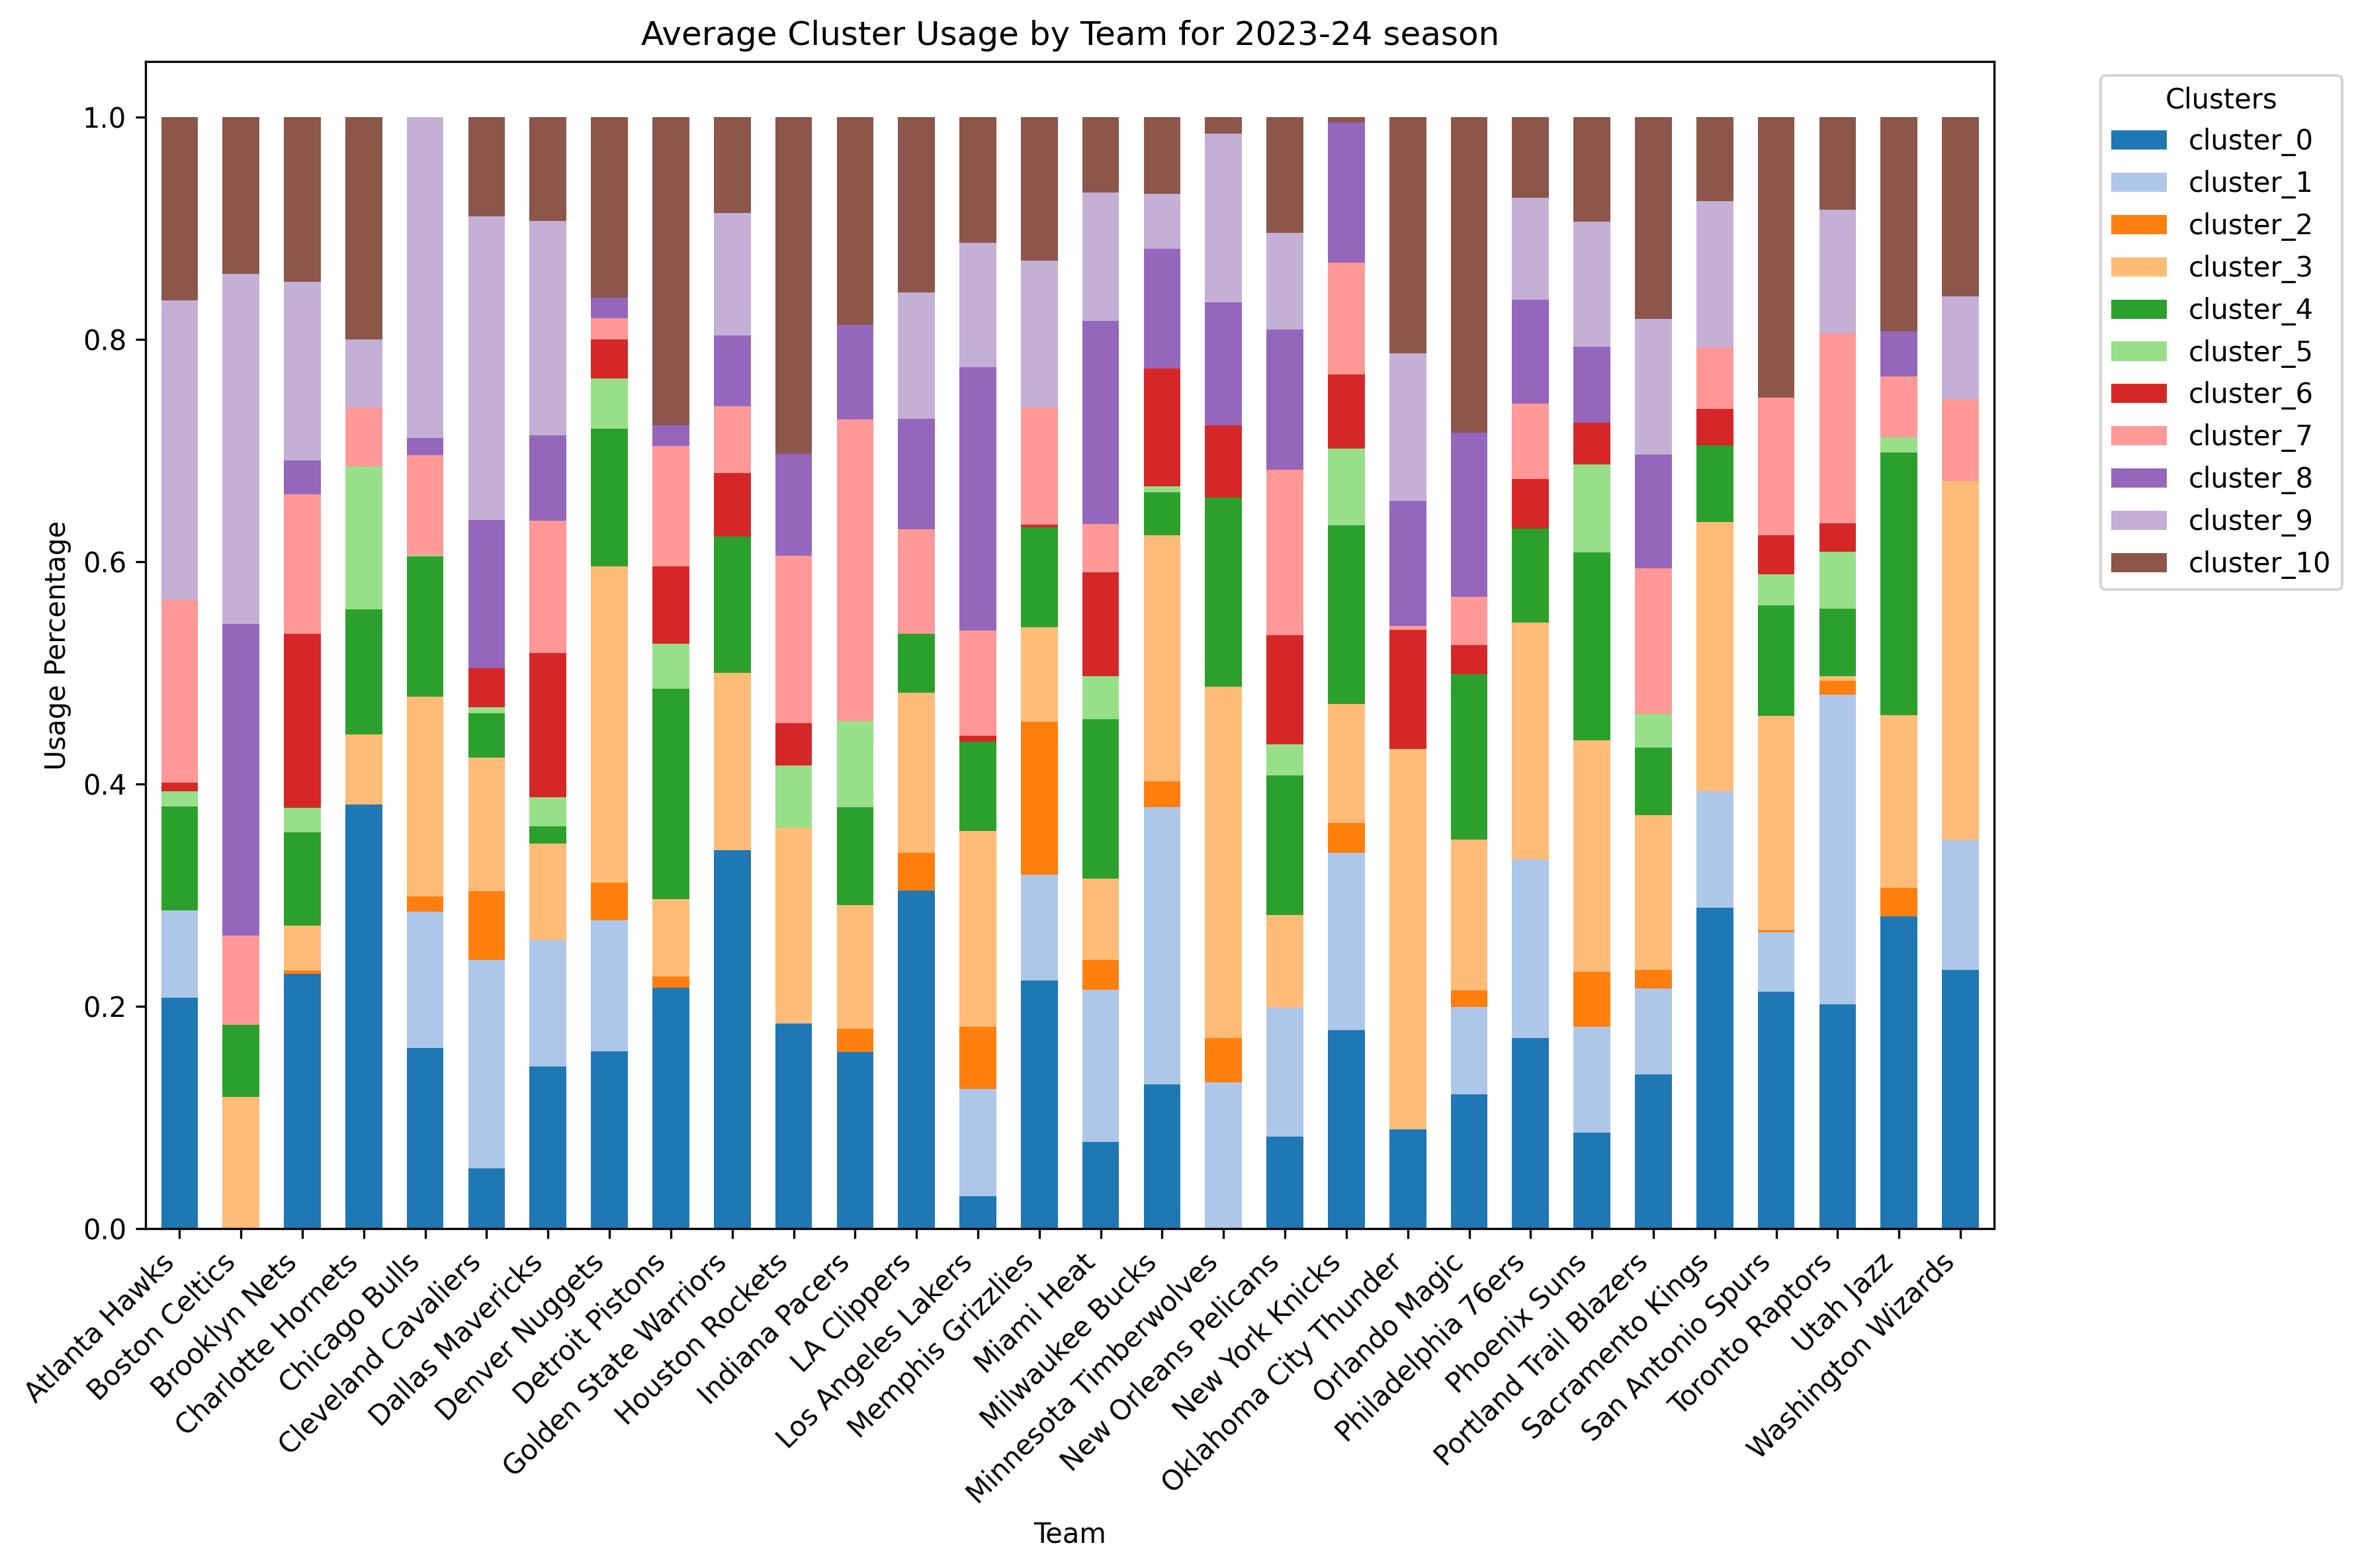

In [182]:
team_clusters = big_df[big_df['SEASON_YEAR'] =='2022-23' ].groupby('TEAM_NAME_x').agg({
    'cluster_0': 'mean',
    'cluster_1': 'mean',
    'cluster_2': 'mean',
    'cluster_3': 'mean',
    'cluster_4': 'mean',
    'cluster_5': 'mean',
    'cluster_6': 'mean',
    'cluster_7': 'mean',
    'cluster_8': 'mean',
    'cluster_9': 'mean',
    'cluster_10': 'mean'
}).reset_index()

team_clusters.iloc[:, 1:] = team_clusters.iloc[:, 1:].div(team_clusters.iloc[:, 1:].sum(axis=1), axis=0)


plt.figure(figsize=(12, 8),dpi = 300)

ax = team_clusters.set_index('TEAM_NAME_x').plot(kind='bar', stacked=True, width = 0.6, ax=plt.gca(), color = plt.cm.tab20.colors)

ax.set_title('Average Cluster Usage by Team for 2023-24 season')
ax.set_xlabel('Team')
ax.set_ylabel('Usage Percentage')
ax.legend(title='Clusters', bbox_to_anchor=(1.05, 1))

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.subplots_adjust(bottom=.25)

plt.tight_layout()
plt.savefig('charts/team_clusters.png')
plt.show()

In [ ]:
cluster_means = big_df.groupby('WL').agg({
    'cluster_0': 'mean',
    'cluster_1': 'mean',
    'cluster_2': 'mean',
    'cluster_3': 'mean',
    'cluster_4': 'mean',
    'cluster_5': 'mean',
    'cluster_6': 'mean',
    'cluster_7': 'mean',
    'cluster_8': 'mean',
    'cluster_9': 'mean',
    'cluster_10': 'mean'
}).reset_index()

cluster_means.set_index('WL', inplace=True)

plt.figure(figsize=(8, 6))

num_clusters = len(cluster_means.columns)
bar_width = 0.4  

indices = np.arange(num_clusters)

plt.bar(indices - bar_width / 2, cluster_means.loc[0, :], width=bar_width, 
        color='firebrick', alpha=0.8, label='Losers')

plt.bar(indices + bar_width / 2, cluster_means.loc[1, :], width=bar_width, 
        color='midnightblue', alpha=0.8, label='Winners')

plt.title('Average Usage Percentage of Clusters by Game Winners and Losers')
plt.xlabel('Clusters')
plt.ylabel('Average Usage Percentage')
plt.xticks(indices, [f'Cluster {i}' for i in range(num_clusters)], rotation=45)
plt.legend(title='Game Outcome')
plt.tight_layout()
plt.savefig('charts/cluster_winner_loser.png')
plt.show()

# Cluster Shot selection

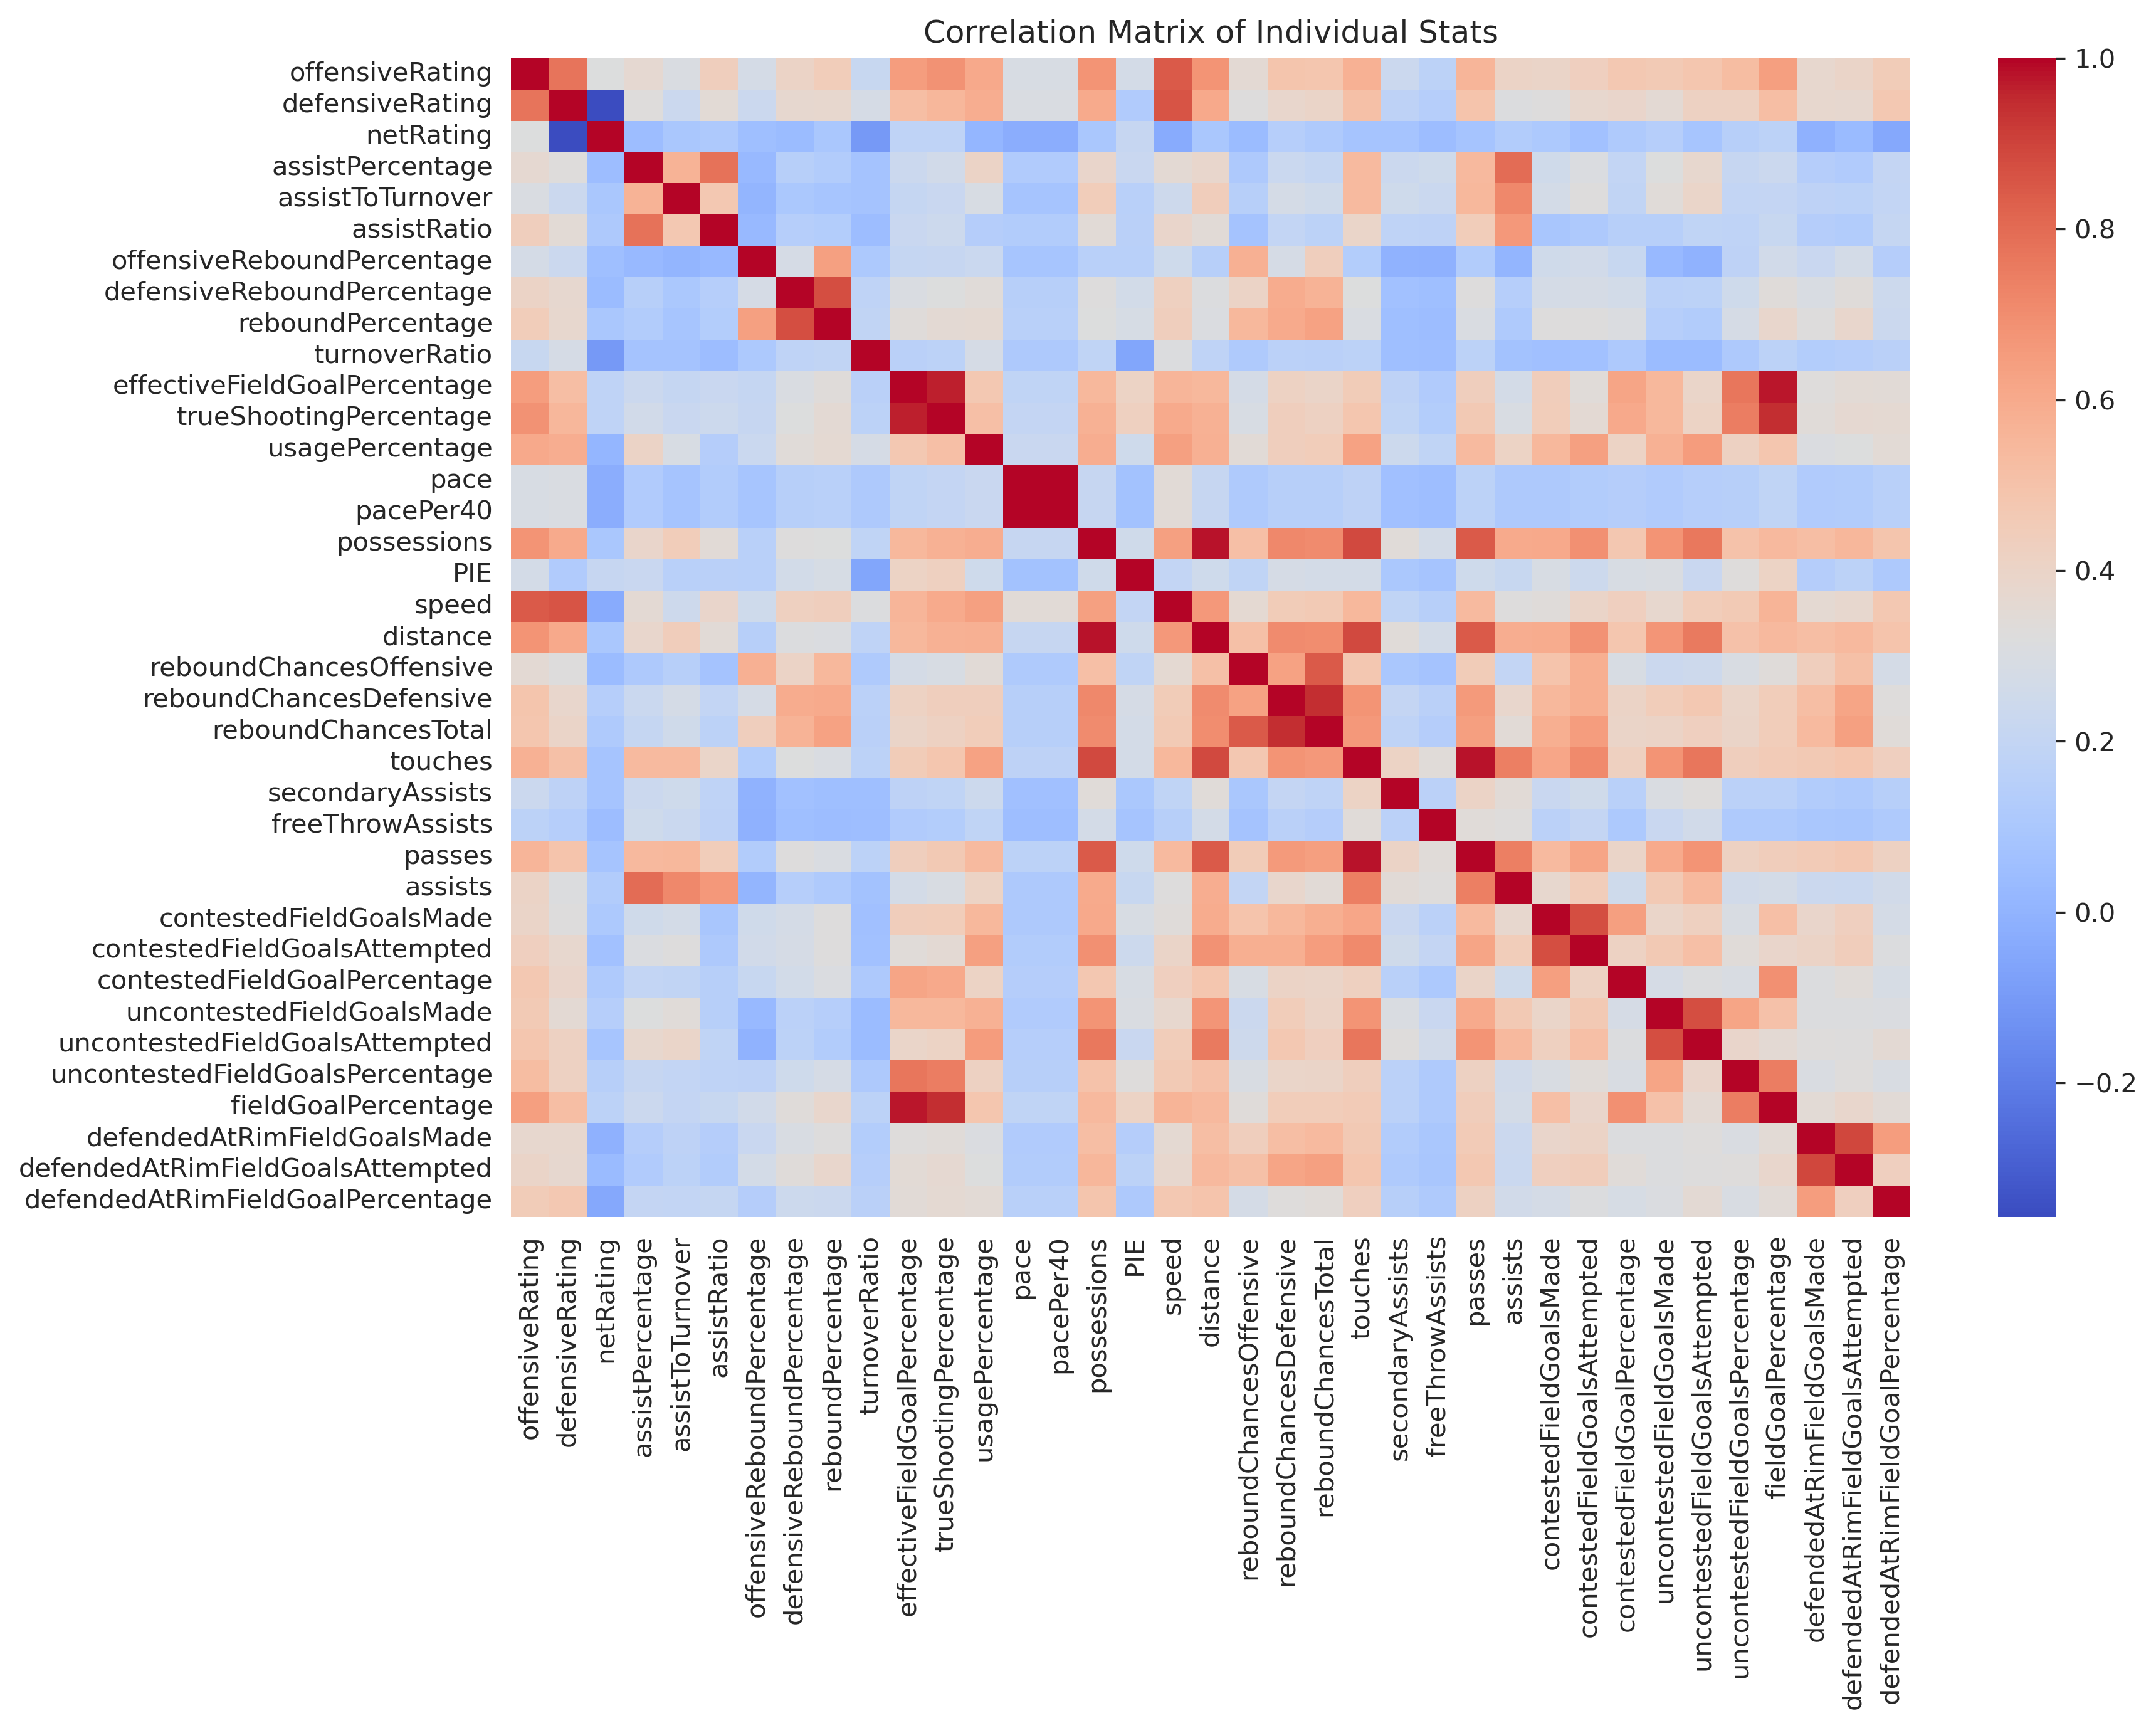

In [87]:
numeric_big_box = big_box.select_dtypes(include=np.number)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
numeric_big_box.drop(['gameId','teamId','personId'],axis=1, inplace=True)
numeric_big_box.drop(numeric_big_box.filter(like='estimated').columns, axis=1,inplace = True)

sns.heatmap(numeric_big_box.corr(), annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Individual Stats')
plt.show()
fig.savefig('individual_correlation_matrix.png', format='png')

# silhouette auc experiment   

In [ ]:
#experimenting with feature importance and K-means using area under silhoutte curve as a indicator of helpfullness, 
def silhouette_auc(X, clusters_range): #calculate the area under the sihouette curve 
    scores = []
    for n_clusters in clusters_range:
        labels = k_means(X,n_clusters,n_rand=1)
        silhouette_avg = silhouette_score(X,labels)
        scores.append(silhouette_avg)
    return np.trapz(scores,clusters_range) # np.trapz, good ol trapizodial method for definate integrals, 

# Wrapper class for silhouette_auc, used to make work with sklearn estimator interface - gotten from GPT so we didnt have to figure out how to write one
class SilhouetteAUCWrapper(BaseEstimator):
    def __init__(self, clusters_range):
        self.clusters_range = clusters_range

    def fit(self, X, y=None):
        return self  # Not used for scoring

    def score(self, X, y=None):
        return silhouette_auc(X, self.clusters_range)


from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
season_prefixs = ['213','214','215','216','217','218','219','220','221','222','223']
games = list(set(map(str, big_box['gameId'])))
season_game_dict = {}


for s in season_prefixs:
    season_games = [game for game in games if game.startswith(s)]
    season_games = [float(g) for g in season_games]
    season_game_dict[s] = season_games
#iterate though season
season_cluster_dict = {}
season_shot_dict = {}
#season_team_data_dict = {}
all_team_data = []

fig, ax = plt.subplots(figsize=(10, 6))


for s in season_game_dict:
    games = season_game_dict[s]
    #get seasons data
    season_big_box = big_box[big_box['gameId'].isin(games)]
    season_team_game_stats = team_game_stats[team_game_stats['GAME_ID'].isin(games)]
    season_shot_chart = player_shotchart_data[player_shotchart_data['GAME_ID'].isin(games)]
    season_player_play_type = player_play_type[player_play_type['SEASON_ID'].astype(str).str[-2:] == str(s)[-2:]]

    #get play type 
    season_player_play_type = season_player_play_type.pivot_table(index= 'PLAYER_ID', columns= ['TYPE_GROUPING','PLAY_TYPE'], values='PERCENTILE').fillna(0)
    season_player_play_type.columns = ['_'.join(col).strip() for col in season_player_play_type.columns.values]
    season_player_play_type.reset_index()

    season_shot_dict[s] = season_shot_chart
    cluster_big_box = season_big_box.copy()
    X = cluster4000(cluster_big_box,season_shot_chart, season_player_play_type)
    
    
    X_scaled = RobustScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns.difference(low_var_columns))


    n_clusters_range = range(5,10)
    sfs = SequentialFeatureSelector(estimator=SilhouetteAUCWrapper(clusters_range=  n_clusters_range))
    sfs.fit(X_scaled)
    selected_indices = sfs.get_support(indices=True)
    selected_feature_names = X_scaled.columns[selected_indices].tolist()
    print(f' selected_features for season {s}: {selected_feature_names}')

# Fun 


In [194]:
X

,offensiveRating,defensiveRating,assistPercentage,assistToTurnover,assistRatio,reboundPercentage,effectiveFieldGoalPercentage,usagePercentage,pacePer40,speed,distance,reboundChancesOffensive,reboundChancesDefensive,reboundChancesTotal,touches,secondaryAssists,freeThrowAssists,passes,assists,contestedFieldGoalsMade,contestedFieldGoalsAttempted,contestedFieldGoalPercentage,uncontestedFieldGoalsMade,uncontestedFieldGoalsAttempted,uncontestedFieldGoalsPercentage,fieldGoalPercentage,defendedAtRimFieldGoalsMade,defendedAtRimFieldGoalsAttempted,defendedAtRimFieldGoalPercentage,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,avg_minutes,games_started,making_percentage_Above_the_Break_3,making_percentage_In_The_Paint_(Non-RA),making_percentage_Left_Corner_3,making_percentage_Mid-Range,making_percentage_Restricted_Area,making_percentage_Right_Corner_3,usage_percentage_Above_the_Break_3,usage_percentage_In_The_Paint_(Non-RA),usage_percentage_Left_Corner_3,usage_percentage_Mid-Range,usage_percentage_Restricted_Area,usage_percentage_Right_Corner_3,making_percentage_Backcourt,usage_percentage_Backcourt,Defensive_Handoff,Defensive_Isolation,Defensive_OffScreen,Defensive_PRRollMan,Defensive_Postup,Defensive_Spotup,Offensive_Cut,Offensive_Handoff,Offensive_Isolation,Offensive_Misc,Offensive_OffRebound,Offensive_OffScreen,Offensive_PRBallHandler,Offensive_PRRollMan,Offensive_Postup,Offensive_Spotup,Offensive_Transition
0,101.067626,100.646763,0.139827,0.754101,19.466906,0.159770,0.465381,0.166784,78.613741,4.115827,1.280791,2.086331,7.755396,9.453237,38.798561,0.143885,0.079137,31.776978,1.589928,0.870504,2.266187,0.344741,1.633094,3.266187,0.477892,0.464281,1.517986,2.561151,0.544892,2.546763,5.589928,0.464482,0.007194,0.079137,0.007194,0.633094,0.812950,0.283935,0.884892,5.007194,5.892086,0.841727,0.482014,0.942446,2.172662,5.733813,0.035971,18.825060,139,14.285714,41.406250,0.000000,44.510978,56.204380,0.000000,0.900901,16.473616,0.128700,64.478764,17.631918,0.386100,0.000000,0.000000,0.0000,0.864,0.0000,0.696333,0.486333,0.730750,0.118333,0.0000,0.000000,0.166667,0.0920,0.7030,0.000000,0.3385,0.553,0.480333,0.414667
1,108.217808,104.571233,0.119397,0.778493,17.575342,0.057589,0.536452,0.161822,77.087397,4.233288,1.868493,1.452055,4.534247,5.945205,32.260274,0.232877,0.150685,22.095890,1.958904,0.917808,2.123288,0.344288,2.369863,5.315068,0.423479,0.426658,1.383562,1.753425,0.702986,3.287671,7.438356,0.426932,1.589041,4.232877,0.363219,1.438356,1.589041,0.528767,0.315068,2.493151,2.808219,0.739726,0.109589,1.150685,1.575342,9.602740,2.219178,26.517808,9,33.714286,57.500000,38.095238,43.877551,60.416667,47.058824,32.228361,7.366483,11.602210,18.047882,17.679558,12.523020,33.333333,0.552486,0.7230,0.608,0.2380,0.761000,0.739000,0.223000,0.238000,0.0000,0.294000,0.786000,0.0000,0.4670,0.632000,0.0000,0.000,0.899000,0.808000
2,99.580000,110.953333,0.416467,2.756000,39.620000,0.043600,0.445533,0.176400,85.998667,4.494000,1.559333,1.133333,3.466667,4.466667,51.533333,0.733333,0.266667,41.666667,5.733333,0.866667,2.400000,0.251867,1.533333,3.866667,0.406400,0.391067,0.933333,0.933333,0.600000,2.400000,6.266667,0.391067,0.533333,1.600000,0.293333,1.466667,1.600000,0.433333,0.266667,1.666667,1.933333,0.466667,0.133333,2.066667,1.200000,6.800000,-4.333333,20.841111,10,33.333333,44.444444,0.000000,36.585366,45.454545,0.000000,25.531915,19.148936,0.000000,43.617021,11.702128,0.000000,0.000000,0.000000,0.0000,0.000,0.0000,0.000000,0.000000,0.972000,0.000000,0.0540,0.000000,0.000000,0.0000,0.0000,0.735000,0.0000,0.000,0.776000,0.000000
3,107.186420,98.620988,0.122284,0.512346,19.735802,0.044667,0.503074,0.136383,81.000741,4.043086,1.180000,0.740741,2.444444,3.123457,26.604938,0.172840,0.172840,20.037037,1.444444,0.51851

For n_clusters = 10 The average silhouette_score is : 0.08855 caliniski harabasz score 105.56


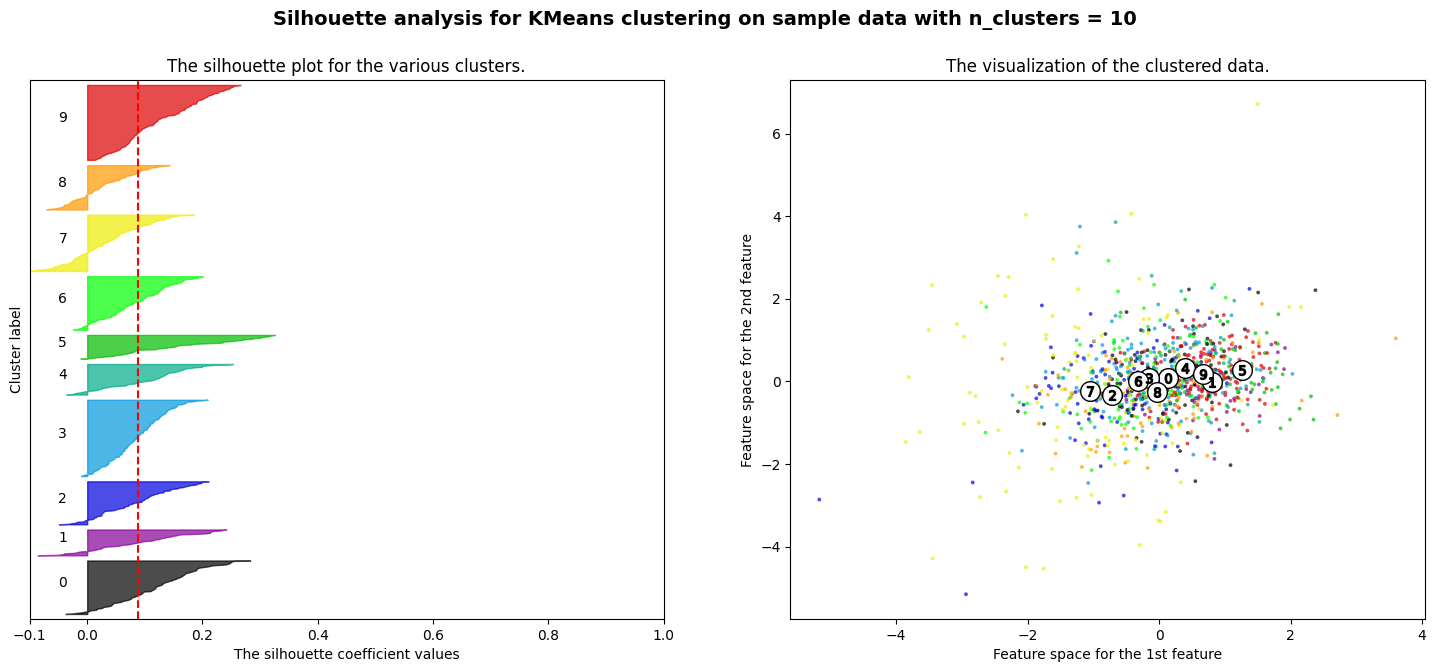

In [201]:
#from sklearn docs

X = scaled_X
range_n_clusters = range(10,11)
for n_clusters in range_n_clusters:
    results = labeled_X['personId']
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=500, init='random')
    cluster_labels = clusterer.fit_predict(X)
    results['cluster'] = cluster_labels


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    labels = clusterer.labels_

    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        round(silhouette_avg,5),
        "caliniski harabasz score",
        round(metrics.calinski_harabasz_score(X, labels),2)
    )
# Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")




    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.savefig('charts/Silhouette_analysis.png')
plt.show()

In [283]:
asdf = labeled_X.copy()
unique_big_box = big_box[['playerSlug', 'personId']].drop_duplicates()
asdf = asdf.merge(unique_big_box, on = 'personId',how = 'inner')
jkl = asdf[['clusters','playerSlug','personId']]
cluster_stats = jkl.merge(big_box.drop_duplicates(subset='personId'), on = 'personId')

In [ ]:
sampled_players = jkl.groupby('clusters').apply(lambda x: x.sample(n=min(len(x), 10)))
sampled_players = sampled_players.reset_index(drop=True)
sampled_players

In [264]:
cluster_max = asdf.drop('nameI',axis = 1).groupby('clusters').agg('mean')
cluster_max.idxmax()

personId                                   0
gameId                                     6
offensiveRating                            7
defensiveRating                            9
assistPercentage                           9
assistToTurnover                           9
assistRatio                                9
reboundPercentage                          3
effectiveFieldGoalPercentage               8
usagePercentage                            7
pacePer40                                  0
speed                                      5
distance                                   7
reboundChancesOffensive                    3
reboundChancesDefensive                    3
reboundChancesTotal                        3
touches                                    7
secondaryAssists                           7
freeThrowAssists                           7
passes                                     7
assists                                    7
contestedFieldGoalsMade                    3
contestedF

In [292]:
cluster_stats_num = cluster_stats.drop(["playerSlug_x", 	"personId", 	"gameId", 	"teamId", 	"teamCity", 	"teamName", 	"teamTricode", 	"teamSlug", 	"firstName", 	"familyName" ,	"nameI" 	,"playerSlug_y" 	,"position" 	,"comment" ,	"minutes"],axis = 1)

cluster_stats_num.groupby('clusters').agg('mean')

,estimatedOffensiveRating,offensiveRating,estimatedDefensiveRating,defensiveRating,estimatedNetRating,netRating,assistPercentage,assistToTurnover,assistRatio,offensiveReboundPercentage,defensiveReboundPercentage,reboundPercentage,turnoverRatio,effectiveFieldGoalPercentage,trueShootingPercentage,usagePercentage,estimatedUsagePercentage,estimatedPace,pace,pacePer40,possessions,PIE,speed,distance,reboundChancesOffensive,reboundChancesDefensive,reboundChancesTotal,touches,secondaryAssists,freeThrowAssists,passes,assists,contestedFieldGoalsMade,contestedFieldGoalsAttempted,contestedFieldGoalPercentage,uncontestedFieldGoalsMade,uncontestedFieldGoalsAttempted,uncontestedFieldGoalsPercentage,fieldGoalPercentage,defendedAtRimFieldGoalsMade,defendedAtRimFieldGoalsAttempted,defendedAtRimFieldGoalPercentage,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,55.462295,52.757377,56.667213,54.727869,-1.202459,-1.969672,0.073344,0.304672,10.259836,0.012393,0.051910,0.032303,3.468033,0.170574,0.200025,0.079639,0.082623,52.858443,55.656557,46.380656,10.303279,0.048615,2.084180,0.345984,0.319672,0.885246,1.180328,8.163934,0.057377,0.040984,6.336066,0.557377,0.147541,0.459016,0.064893,0.270492,0.737705,0.120525,0.141262,0.278689,0.368852,0.145492,0.450820,1.286885,0.141295,0.163934,0.540984,0.096172,0.254098,0.327869,0.107926,0.139344,0.524590,0.663934,0.114754,0.090164,0.229508,0.426230,1.319672,-0.385246
1,64.653012,62.727711,66.884337,65.365060,-2.238554,-2.642169,0.047096,0.150602,5.075904,0.063904,0.124229,0.087337,9.319277,0.327386,0.356398,0.099795,0.103349,63.576867,66.776627,55.647229,14.831325,0.060711,2.637229,0.502651,1.879518,2.301205,3.951807,10.903614,0.060241,0.024096,7.867470,0.277108,0.566265,1.156627,0.262602,0.433735,0.698795,0.248651,0.322506,0.590361,0.963855,0.288361,1.024096,1.879518,0.322518,0.036145,0.084337,0.036145,0.590361,0.903614,0.201313,0.686747,1.060241,1.746988,0.240964,0.301205,0.481928,1.120482,2.674699,-0.096386
2,57.465217,55.970435,63.674783,59.336522,-6.210435,-3.365217,0.036704,0.127913,4.346957,0.009417,0.054800,0.033704,6.495652,0.209991,0.233643,0.085696,0.089513,72.311304,78.770522,65.642087,13.913043,0.018539,2.332870,0.482174,0.478261,1.130435,1.591304,9.443478,0.052174,0.017391,6.713043,0.330435,0.252174,0.634783,0.103826,0.513043,1.400000,0.157774,0.174974,0.286957,0.469565,0.158696,0.765217,2.043478,0.175026,0.347826,1.078261,0.101730,0.304348,0.321739,0.130435,0.113043,0.617391,0.730435,0.173913,0.060870,0.391304,0.643478,2.182609,-0.304348
3,87.670492,88.185246,95.840984,96.122951,-8.178689,-7.945902,0.074689,0.441475,7.919672,0.073279,0.181574,0.124525,13.142623,0.447951,0.476705,0.190279,0.194689,91.950164,91.461475,76.217541,49.622951,0.082082,3.880492,1.676393,5.409836,8.655738,13.295082,40.295082,0.147541,0.114754,27.672131,1.311475,2.327869,5.180328,0.401361,1.983607,3.885246,0.411082,0.435705,2.180328,3.803279,0.501180,4.311475,9.114754,0.435934,0.278689,0.688525,0.081475,1.934426,2.786885,0.396049,2.032787,4.819672,6.852459,0.639344,0.819672,1.836066,2.426230,10.836066,-2.967213
4,62.086395,62.038776,69.428571,68.689796,-7.342177,-6.654422,0.047544,0.211361,6.867347,0.026728,0.080701,0.052776,7.507483,0.265340,0.277558,0.100116,0.103374,65.930272,70.641497,58.867415,20.108844,0.036952,2.761837,0.702789,1.176871,2.244898,3.306122,14.047619,0.054422,0.061224,10.088435,0.476190,0.482993,1.102041,0.191823,0.734694,1.809524,0.201306,0.227354,0.591837,0.986395,0.267034,1.251701,2.979592,0.227422,0.408163,1.081633,0.159340,0.319728,0.517007,0.112585,0.360544,1.197279,1.557823,0.340136,0.210884,0.503401,0.952381,3.231293,-0.585034
5,69.795082,69.085246,69.346721,67.364754,0.451639,1.717213,0.